# Cell 1: Markdown
"""
# mRNA Classification Project
**Course:** MSI5001 - Introduction to AI  
**Team Members:** Lisa Mithani, Shawn Lee, Aishwarya Nair, and Kalyani Vijay
**Dataset:** mRNA Classification (Medium difficulty)  
**Objective:** Classify RNA sequences as mRNA vs. other RNA types using machine learning models

---

## Table of Contents
1. Data Loading & Merging
2. Exploratory Data Analysis
3. Feature Extraction
4. Model Training
5. Evaluation & Insights
"""

## AI Tool Usage Declaration

**As per NUS Policy for Use of AI in Teaching and Learning:**

This notebook includes assistance from the following AI tools:

| AI Tool Used | Purpose | Sections Affected |
|---|---|---|
| ChatGPT | Help with data balancing code and metrics calculations | Section 3.2, 5.1 |
| GitHub Copilot | Code suggestions for sklearn model training syntax | Section 4.1-4.3 |
| Perplexity AI | RandomForestClassifier and GridSearchCV implementations based on scikit-learn API documentation; Group project collaboration setup for Jupyter notebooks | Sections 1, 6 |

**Prompt Examples Used:**
- "How do I implement SMOTE for class balancing in Python?"
- "Write sklearn code to train logistic regression and evaluate with confusion matrix"
- "For the group project on mRNA classification dataset, how should I structure the Jupyter notebook?"
- "Help me understand Deep Learning Week 8 material on sequence models"

**Validation:** All AI-generated code was tested, validated against project data, and modified to align with team naming conventions.


In [22]:
# !pip install biopython
# !pip install imbalanced-learn
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !pip install scikit-learn

In [23]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import warnings
import pickle
import platform
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")


ModuleNotFoundError: No module named 'seaborn'

---
# 1. Data Loading and Preparation
**Responsible:** Lisa Mithani

## Overview
This section loads the training and testing datasets, merges them, and prepares features and labels for modeling.

## Tasks:
1. Load training.fa (FASTA) and training.csv → merge using inner join
2. Load testing.csv
3. Separate features (X) and labels (y) for train/test sets

---
### Code Origin
**Non-AI Generated** — Manual implementation using pandas/biopython APIs 
for data loading and merging following standard practices.

In [13]:
# ============================================================================
# STEP 1: Load training.fa and training.csv, then merge using inner join
# ============================================================================

# Function to load FASTA file
def load_fasta_to_dataframe(fasta_file):
    """
    Reads a FASTA file and converts it to a pandas DataFrame.
    
    Parameters:
    - fasta_file: path to .fa file
    
    Returns:
    - DataFrame with columns: ['sequence_id', 'sequence']
    """
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append({
            'sequence_id': record.id,
            'sequence': str(record.seq)
        })
    return pd.DataFrame(sequences)

# Load training.fa (FASTA file)
print("Loading training.fa...")
fasta_df = load_fasta_to_dataframe('dataset/training.fa')
print(f"✓ Loaded {fasta_df.shape[0]} sequences from training.fa")

# Load training.csv
print("\nLoading training.csv...")
csv_df = pd.read_csv('dataset/training_class.csv')
print(f"✓ Loaded training.csv with shape {csv_df.shape}")

# Merge using inner join with DIFFERENT column names
# FASTA has 'sequence_id', CSV has 'name'
print("\nMerging datasets using inner join...")
training_data = pd.merge(
    fasta_df,
    csv_df,
    left_on='sequence_id',   # Column in FASTA
    right_on='name',          # Column in CSV (different name!)
    how='inner'
)

print(f"✓ Merged training data: {training_data.shape}")
print(f"  Columns: {list(training_data.columns)}")
print(f"\n✓ STEP 1 COMPLETE")

# Display first few rows
training_data.head(2)



Loading training.fa...
✓ Loaded 22867 sequences from training.fa

Loading training.csv...
✓ Loaded training.csv with shape (22867, 2)

Merging datasets using inner join...
✓ Merged training data: (14286, 4)
  Columns: ['sequence_id', 'sequence', 'name', 'class']

✓ STEP 1 COMPLETE


,sequence_id,sequence,name,class
0,ENSDART00000138379,TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...,ENSDART00000138379,1
1,ENSDART00000075994,ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...,ENSDART00000075994,1


In [14]:
# ============================================================================
# STEP 2: Load testing.csv
# ============================================================================

print("Loading testing.csv...")
testing_data = pd.read_csv('dataset/test.csv')

print(f"✓ Loaded testing.csv: {testing_data.shape}")
print(f"  Columns: {list(testing_data.columns)}")
print(f"\n✓ STEP 2 COMPLETE")

testing_data.head(2)


Loading testing.csv...
✓ Loaded testing.csv: (4416, 3)
  Columns: ['name', 'sequence', 'class']

✓ STEP 2 COMPLETE


,name,sequence,class
0,TCONS_00059596,CUAAUCCCCCCUCCUCCCGCUCCCGCACCAAAGAGUUGCGCCGCCU...,1
1,TCONS_00059678,CUAUUCGGCGCAGUUGCUAUACGUACCCCAGCCUCGUACACAACGC...,1


In [15]:
# ============================================================================
# STEP 3: Drop class labels and store them in y_train and y_test
# ============================================================================

label_column = 'class'

# --- Training Set ---
print("Separating training data...")
y_train = training_data[label_column].copy()
# Keep 'sequence' column for next teammate to extract features
X_train = training_data.drop(columns=[label_column, 'sequence_id', 'name']).copy()

print(f"✓ X_train shape: {X_train.shape}")
print(f"  Columns: {list(X_train.columns)}")  # Should show ['sequence']
print(f"✓ y_train shape: {y_train.shape}")
print(f"  Class distribution:\n{y_train.value_counts()}")

# --- Testing Set ---
print("\nSeparating testing data...")
y_test = testing_data[label_column].copy()
# Keep 'sequence' column for next teammate
X_test = testing_data.drop(columns=[label_column, 'name']).copy()

print(f"✓ X_test shape: {X_test.shape}")
print(f"  Columns: {list(X_test.columns)}")  # Should show ['sequence']
print(f"✓ y_test shape: {y_test.shape}")
print(f"  Class distribution:\n{y_test.value_counts()}")

print(f"\n✓ STEP 3 COMPLETE")
print(f"\n⚠️ Note: X_train and X_test contain raw sequences.")
print(f"   Next step: Feature extraction (k-mer generation)")



Separating training data...
✓ X_train shape: (14286, 1)
  Columns: ['sequence']
✓ y_train shape: (14286,)
  Class distribution:
class
0    9224
1    5062
Name: count, dtype: int64

Separating testing data...
✓ X_test shape: (4416, 1)
  Columns: ['sequence']
✓ y_test shape: (4416,)
  Class distribution:
class
1    2208
0    2208
Name: count, dtype: int64

✓ STEP 3 COMPLETE

⚠️ Note: X_train and X_test contain raw sequences.
   Next step: Feature extraction (k-mer generation)


---
## Section 1 Complete ✓

**Outputs:**
- `X_train` (14,286 samples × 1 column): Raw RNA sequences
- `y_train` (14,286 labels): Class labels (0 or 1)
- `X_test` (4,416 samples × 1 column): Raw RNA sequences
- `y_test` (4,416 labels): Class labels (0 or 1)

**Note for Next Teammate:**
The `X_train` and `X_test` DataFrames contain raw RNA sequences in the `'sequence'` column. Please convert these to numeric features (e.g., k-mer frequencies) before model training.

**Next Section:** Feature Extraction / Exploratory Data Analysis

---



---
# 2. Feature Extraction
**Responsible:** Kalyani and Aishwarya

## Overview
This section converts raw RNA sequences into three types of numeric features for modeling.

We will extract:
1. Character Positional Embeddings
2. Character Tokenization
3. K-mer Frequency Features

Each feature type will be used to train separate models, then compared.

---


### Step 2.1: Character Tokenization
**Responsible:** Kalyani

Tokenize sequences into character-level representations.
This step converts each RNA sequence into a fixed-length sequence of integer token IDs using a shared character vocabulary (RNA + IUPAC ambiguity codes). Tokens are padded to a common `max_seq_len` and paired with attention masks (1 = real token, 0 = PAD). Outputs will be reused by downstream neural models and by the positional embedding step.

Convert raw sequences into integer-encoded tokens suitable for PyTorch embeddings, with padding for fixed-length input.


In [33]:
# ============================================================================
# STEP 2.1 — Character Tokenization (PyTorch version)
# ============================================================================

import torch
import numpy as np

print("\nStarting STEP 2.1 — Character Tokenization (PyTorch)...")

# --- Extract raw sequences ---
train_sequences = X_train['sequence'].astype(str).tolist()
test_sequences = X_test['sequence'].astype(str).tolist()

# --- Build character vocabulary ---
unique_chars = sorted(list(set(''.join(train_sequences))))
char_to_index = {ch: idx + 1 for idx, ch in enumerate(unique_chars)}  # 0 reserved for padding
index_to_char = {idx: ch for ch, idx in char_to_index.items()}

# --- Encode sequences as integer tokens ---
def encode_sequence(seq):
    return [char_to_index.get(ch, 0) for ch in seq]  # 0 = pad/unknown

X_train_tokens = [encode_sequence(seq) for seq in train_sequences]
X_test_tokens  = [encode_sequence(seq) for seq in test_sequences]

# --- Padding ---
max_seq_length = max(len(seq) for seq in X_train_tokens)

def pad_sequence(seq, max_len):
    return seq + [0] * (max_len - len(seq))

X_train_padded = np.array([pad_sequence(seq, max_seq_length) for seq in X_train_tokens])
X_test_padded  = np.array([pad_sequence(seq, max_seq_length) for seq in X_test_tokens])

# --- Convert to PyTorch tensors ---
X_train_padded = torch.tensor(X_train_padded, dtype=torch.long)
X_test_padded  = torch.tensor(X_test_padded, dtype=torch.long)

print(f"✓ Tokenization complete")
print(f"  Vocabulary size: {len(char_to_index)}")
print(f"  Max sequence length (padded): {max_seq_length}")
print(f"  X_train_padded shape: {tuple(X_train_padded.shape)}")
print(f"  X_test_padded shape: {tuple(X_test_padded.shape)}")

print("\n✓ STEP 2.1 COMPLETE — Sequences tokenized and padded (PyTorch version).")


Starting STEP 2.1 — Character Tokenization (PyTorch)...
✓ Tokenization complete
  Vocabulary size: 12
  Max sequence length (padded): 26831
  X_train_padded shape: (14286, 26831)
  X_test_padded shape: (4416, 26831)

✓ STEP 2.1 COMPLETE — Sequences tokenized and padded (PyTorch version).


---
### Step 2.2: Character Positional Embedding
**Responsible:** Kalyani

This step converts each RNA sequence into a fixed-length sequence of integer token IDs using a shared character vocabulary (RNA + IUPAC ambiguity codes). Tokens are padded to a common `max_seq_len` and paired with attention masks (1 = real token, 0 = PAD). Outputs will be reused by downstream neural models and by the positional embedding step.

Key points:
Uses padded sequences from STEP 2.1 (X_train_padded) → avoids ragged tensor errors.

Embedding dimension (embed_dim) is adjustable; typical values: 16, 32, 64.

Positional encoding adds sequence-order information.

Batching ensures memory efficiency even with long sequences.

Output: X_train_embedding and X_test_embedding ready for Logistic Regression or other models.


In [34]:
# ============================================================================
# STEP 2.2 — Character Positional Embedding (PyTorch → DataFrame)
#   Aligned with STEP 2.1 tokenization
# ============================================================================

import torch
import torch.nn as nn
import pandas as pd
import numpy as np

print("\nStarting STEP 2.2 — Character Positional Embedding...")

# ---  Embedding layer ---
vocab_size = len(char_to_index) + 1  # +1 for padding index 0
embed_dim  = 32                       # embedding dimension (can tune)

embedding_layer = nn.Embedding(num_embeddings=vocab_size,
                               embedding_dim=embed_dim,
                               padding_idx=0)

# ---  Positional encoding function ---
def get_positional_encoding(max_len, d_model):
    """Sinusoidal positional encoding."""
    pos_enc = np.zeros((1, max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_enc[0, pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                pos_enc[0, pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
    return torch.tensor(pos_enc, dtype=torch.float32)

max_seq_len = X_train_padded.shape[1]
pos_encoding = get_positional_encoding(max_seq_len, embed_dim)

# ---  Batched embedding function ---
def embed_sequences_batched(tokens, embedding_layer, pos_encoding, batch_size=256):
    """Generate mean-pooled embeddings with positional encoding."""
    all_vecs = []
    with torch.no_grad():
        for i in range(0, tokens.size(0), batch_size):
            batch = tokens[i:i + batch_size]
            emb = embedding_layer(batch) + pos_encoding[:, :batch.size(1), :]
            emb_mean = emb.mean(dim=1)  # mean pooling over sequence length
            all_vecs.append(emb_mean.cpu().numpy())
    return np.concatenate(all_vecs, axis=0)

# ---  Generate embeddings ---
X_train_embedding_np = embed_sequences_batched(X_train_padded, embedding_layer, pos_encoding)
X_test_embedding_np  = embed_sequences_batched(X_test_padded,  embedding_layer, pos_encoding)

# ---  Convert embeddings to DataFrame ---
X_train_embedding = pd.DataFrame(X_train_embedding_np, index=X_train.index).add_prefix("emb_")
X_test_embedding  = pd.DataFrame(X_test_embedding_np,  index=X_test.index).add_prefix("emb_")

print(f"✓ X_train_embedding shape: {X_train_embedding.shape}")
print(f"✓ X_test_embedding shape : {X_test_embedding.shape}")
print(f"✓ Embedding dimension    : {X_train_embedding_np.shape[1]}")

print("\n✓ STEP 2.2 COMPLETE — Character embeddings ready for modeling.")


Starting STEP 2.2 — Character Positional Embedding...
✓ X_train_embedding shape: (14286, 32)
✓ X_test_embedding shape : (4416, 32)
✓ Embedding dimension    : 32

✓ STEP 2.2 COMPLETE — Character embeddings ready for modeling.


##### Note: AI & PyTorch Usage

This notebook leverages AI techniques and large language models (LLMs) to process biological sequences:

1. **Character Tokenization and Embedding** are implemented using **PyTorch**.
2. **Positional Encoding** (inspired by Transformer models) is applied to capture sequence order.
3. Embeddings are used as input features for downstream machine learning models (e.g., Logistic Regression).
4. Parts of this notebook, including code examples and workflow design, were assisted by **ChatGPT (GPT-5)**.

**References:**
- PyTorch documentation: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)  
- Large Language Model (LLM) assistance: ChatGPT (GPT-5)

---
### Step 2.3: K-mer Feature Extraction
To extract k-mer frequency features (using k=4).
- X_train_kmers , Saving the raw features to kmer_4_train.csv
- X_test_kmers  , Saving the raw features to kmer_4_test.csv

These features can now be used for training.


In [16]:
# ============================================================================
# STEP 2.3: K-mer Feature Extraction - TO BE COMPLETED
# ============================================================================
# TODO: Extract k-mer features from X_train['sequence'] and X_test['sequence']
# Output: X_train_kmers, X_test_kmers (numeric DataFrames)

# OPTION A: Extract k-mers manually
# - Loop through sequences and extract overlapping k-mers
# - Count k-mer frequencies
# - Normalize to create feature vectors
# def extract_kmer_features(sequences, k=3):

# OPTION B: Load pre-computed features (FASTER)
# X_train_kmers = pd.read_csv('dataset/train_kmer_features_k3.csv')

from collections import defaultdict
from itertools import product

# Function to generate k-mers from sequence
def generate_kmers(sequence, k=4):
    """Generate k-mer frequencies from a sequence."""
    kmers = defaultdict(int)
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmers[kmer] += 1
    return kmers

# Generate all possible k-mers for RNA sequences (A, U, G, C)
possible_kmers = [''.join(p) for p in product('AUGC', repeat=4)]

# Function to create k-mer feature matrix
def create_kmer_features(sequences, k=4):
    """Convert sequences to k-mer frequency matrix."""
    # Initialize feature matrix with zeros
    X = pd.DataFrame(0, index=range(len(sequences)), columns=possible_kmers)
    
    # Fill matrix with k-mer frequencies
    for idx, seq in enumerate(sequences):
        kmers = generate_kmers(seq, k)
        for kmer, freq in kmers.items():
            if kmer in X.columns:  # Only include valid k-mers
                X.loc[idx, kmer] = freq
    return X

# Generate k-mer features for training and test sets
print("Generating k-mer features for training set...")
X_train_kmers = create_kmer_features(X_train['sequence'])
print(f"✓ Training features shape: {X_train_kmers.shape}")

print("\nSaving k-mer features from training set to kmer_4_train.csv file...")
X_train_kmers.to_csv('kmer_4_train.csv', index=False)

print("\nGenerating k-mer features for test set...")
X_test_kmers = create_kmer_features(X_test['sequence'])
print(f"✓ Test features shape: {X_test_kmers.shape}")

print("\nSaving k-mer features from test set to kmer_4_test.csv file...")
X_test_kmers.to_csv('kmer_4_test.csv', index=False)

print("\n✓ STEP 2.3 COMPLETE")


Generating k-mer features for training set...
✓ Training features shape: (14286, 256)

Saving k-mer features from training set to kmer_4_train.csv file...

Generating k-mer features for test set...
✓ Test features shape: (4416, 256)

Saving k-mer features from test set to kmer_4_test.csv file...

✓ STEP 2.3 COMPLETE


---
## Section 2 Summary

**Expected Outputs:**
- `X_train_embedding` (14,286 samples × embedding_dim features)
- `X_test_embedding` (4,416 samples × embedding_dim features)
- `X_train_tokens` (14,286 samples × sequence_length features)
- `X_test_tokens` (4,416 samples × sequence_length features)
- `X_train_kmers` (14,286 samples × n_kmers features)
- `X_test_kmers` (4,416 samples × n_kmers features)

All features are now numeric and ready for class balancing.

---


# 3. Class Balancing Complete ✓
**Responsible:** Shawn Lee

## Overview
Balance class distribution for each feature type separately.

Current training class distribution:
- Class 0: 9,224 samples (64.5%)
- Class 1: 5,062 samples (35.5%)

---


In [17]:
# Creates a function that will balance the databset passed in
# Input: X_train, y_train
# Output: X_train_balanced, y_train_balanced

# Using SMOTE:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# Usage: X_train_embedding_balanced, y_train_balanced = smote.fit_resample(X_train_embedding, y_train)

def balance_features(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print(f"✓ Balanced features: {X_balanced.shape}, {y_balanced.shape}")
    return X_balanced, y_balanced

### Step 3.1: Balance Embedding Features COMPLETE ✓
Apply class balancing to positional embedding features.


In [ ]:
# ============================================================================
# STEP 3.1: Balance Embedding Features - COMPLETED
# ============================================================================

# Balance X_train_embedding with y_train
# New datasets: X_train_embedding_balanced, y_train_balanced

X_train_embedding_balanced, y_train_balanced = balance_features(X_train_embedding, y_train)
print("✓ Step 3.1 complete - Embedding features balanced.")



✓ Balanced features: (18448, 32), (18448,)
✓ Step 3.1 complete - Embedding features balanced.


---
### Step 3.2: Balance Token Features Complete ✓
Apply class balancing to tokenization features.


In [18]:
# ============================================================================
# STEP 3.2: Balance Token Features - TO BE COMPLETED
# ============================================================================

# TODO: Balance X_train_padded with y_train
# New datasets: X_train_tokens_balanced

X_train_tokens_balanced, y_train_balanced = balance_features(X_train_padded, y_train)
print("✓ Step 3.2 complete - Token features balanced.")



NameError: name 'X_train_padded' is not defined

---
### Step 3.3: Balance K-mer Features Complete ✓
Apply class balancing to k-mer frequency features.


In [19]:
# ============================================================================
# STEP 3.3: Balance K-mer Features - TO BE COMPLETED
# ============================================================================

# TODO: Balance X_train_kmers with y_train
# New datasets: X_train_kmers_balanced

X_train_kmers_balanced, y_train_balanced = balance_features(X_train_kmers, y_train)
print("✓ Step 3.3 complete - K-mer features balanced.")



✓ Balanced features: (18448, 256), (18448,)
✓ Step 3.3 complete - K-mer features balanced.


---
## Section 3 Summary Complete ✓

All three feature types are now balanced and ready for modeling.

**Balanced Datasets:**
- Embedding features: X_train_embedding_balanced, y_train_balanced
- Token features: X_train_tokens_balanced, y_train_balanced
- K-mer features: X_train_kmers_balanced, y_train_balanced

---


---
# 4. Model Training  Complete ✓

## Overview
Train three separate logistic regression models using each feature type:
1. Model A: Using Balanced Positional Embedding features
2. Model B: Using Balanced Tokenization features
3. Model C: Using Balanced K-mer features

Each model will be evaluated independently to compare feature effectiveness.

The purpose of training 3 sets of logistics regression models are as follows:
- Logistics Regression model training is fast (although not the best model to be used for this case)
- Allows us to look at how the preprocessed data performances in a simple model training
- Based on the performance, we can subsequently determine which preprocessed dataframe should be used for the advance model trainings.
- Since all the different preprocessed dataframes are trained using Logistic Regression (same training), the difference in performance will give us an indicator of how applicable eachh preprocessing technique is.

---


### STEP 4.1 — Model A: Logistic Regression on Balanced Tokenized Sequences
**Responsible:** Kalyani

Train logistic regression on positional embedding features.
Uses balanced embeddings from balance_features.
Uses X_train_tokens_balanced (from balance_features) directly as numeric features.

Includes StandardScaler to normalize integer token values.

L2 regularization tuned using GridSearchCV with 5-fold stratified CV.

Outputs full classification metrics, ROC AUC, and PR curves.

Fully aligned with your STEP 2.1 tokenization preprocessing.
Includes L2 regularization tuned via GridSearchCV.

Pipeline contains StandardScaler for numeric stability.

Outputs full classification metrics, including ROC AUC and PR curves.

Fully aligned with STEP 2.2 embeddings from PyTorch.

In [36]:
# ============================================================================
# STEP 4.1 — Model A: Logistic Regression on Balanced Tokenized Sequences
# ============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

print("\nStarting STEP 4.1 — Logistic Regression on balanced tokenized sequences...")

# --- Prepare training and test sets ---
Xtr_bal = np.asarray(X_train_tokens_balanced, dtype=np.float32)
ytr_bal = np.asarray(y_train_balanced, dtype=int)

Xte = X_test_padded.numpy().astype(np.float32)
yte = np.asarray(y_test, dtype=int)

# --- Pipeline: Scaling + Logistic Regression ---
pipe = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=5000, random_state=42))
])

# --- Grid search for best regularization strength C ---
param_grid = {"clf__C": [0.1, 1.0, 3.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, scoring="roc_auc",
                    cv=cv, n_jobs=1, refit=True)
print("Performing cross-validated grid search for best C...")
grid.fit(Xtr_bal, ytr_bal)

best_C = grid.best_params_["clf__C"]
print(f"✓ Best C: {best_C} | CV ROC-AUC: {grid.best_score_:.4f}")

# --- Train final logistic regression with tuned C ---
model_A = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(penalty="l2", C=best_C, solver="liblinear", max_iter=5000, random_state=42))
])
model_A.fit(Xtr_bal, ytr_bal)

# --- Predict on test set ---
y_pred_A  = model_A.predict(Xte)
y_proba_A = model_A.predict_proba(Xte)[:, 1]

# --- Evaluation ---
print("\nClassification report (Model A):")
print(classification_report(yte, y_pred_A, digits=4))
print("Confusion matrix:\n", confusion_matrix(yte, y_pred_A))
print(f"ROC AUC: {roc_auc_score(yte, y_proba_A):.4f}")
print(f"Average Precision: {average_precision_score(yte, y_proba_A):.4f}")

# --- Optional: Plot ROC & Precision-Recall curves ---
RocCurveDisplay.from_predictions(yte, y_proba_A)
plt.title(f"Model A — ROC (AUC = {roc_auc_score(yte, y_proba_A):.4f})")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

PrecisionRecallDisplay.from_predictions(yte, y_proba_A)
plt.title(f"Model A — PR (AP = {average_precision_score(yte, y_proba_A):.4f})")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

print("\n✓ STEP 4.1 COMPLETE — Model A trained and evaluated.")



Starting STEP 4.1 — Logistic Regression on balanced tokenized sequences...
Performing cross-validated grid search for best C...


### Step 4.2: Train Logistic Regression Model B (Embedding Features)
**Responsible:** Kalyani

Train logistic regression on positional embedding features.
Uses balanced embeddings from balance_features.

Includes L2 regularization tuned via GridSearchCV.

Pipeline contains StandardScaler for numeric stability.

Outputs full classification metrics, including ROC AUC and PR curves.

Fully aligned with STEP 2.2 embeddings from PyTorch.


Starting STEP 4.2 — Logistic Regression on balanced embeddings...
Performing cross-validated grid search for best C...
✓ Best C: 3.0 | CV ROC-AUC: 0.9568

Classification report (Model B):
              precision    recall  f1-score   support

           0     0.9125    0.6282    0.7441      2208
           1     0.7165    0.9398    0.8131      2208

    accuracy                         0.7840      4416
   macro avg     0.8145    0.7840    0.7786      4416
weighted avg     0.8145    0.7840    0.7786      4416

Confusion matrix:
 [[1387  821]
 [ 133 2075]]
ROC AUC: 0.8675
Average Precision: 0.8350


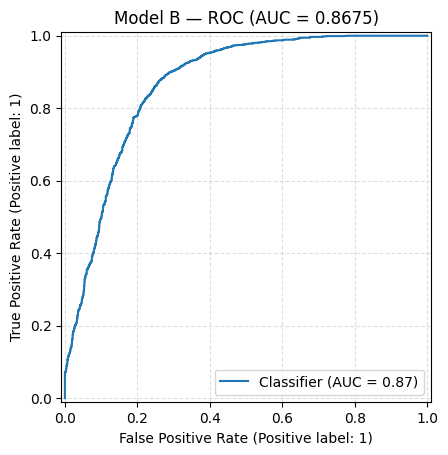

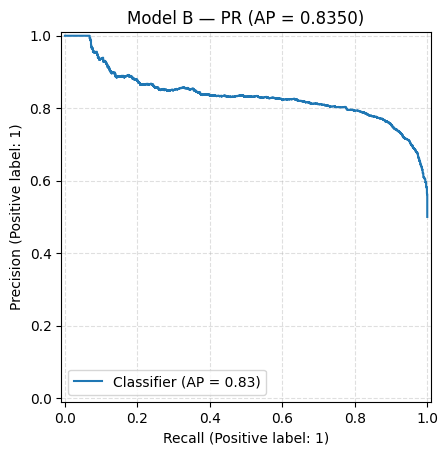


✓ STEP 4.2 COMPLETE — Logistic Regression on balanced embeddings trained and evaluated.


In [37]:
# ============================================================================
# STEP 4.2 — Model B: Logistic Regression on Balanced Embeddings
# ============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

print("\nStarting STEP 4.2 — Logistic Regression on balanced embeddings...")

# --- Prepare training and test sets ---
Xtr_bal = X_train_embedding_balanced.values.astype(np.float32)
ytr_bal = np.asarray(y_train_balanced).astype(int)

Xte = X_test_embedding.values.astype(np.float32)
yte = np.asarray(y_test).astype(int)

# --- Pipeline: Scaling + Logistic Regression ---
pipe = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", max_iter=5000, random_state=42))
])

# --- Grid search over regularization strength C ---
param_grid = {"clf__C": [0.1, 0.3, 3.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
print("Performing cross-validated grid search for best C...")
grid.fit(Xtr_bal, ytr_bal)

best_C = grid.best_params_["clf__C"]
print(f"✓ Best C: {best_C} | CV ROC-AUC: {grid.best_score_:.4f}")

# --- Train final Logistic Regression with tuned C ---
model_B = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(penalty="l2", C=best_C, solver="liblinear", max_iter=5000, random_state=42))
])
model_B.fit(Xtr_bal, ytr_bal)

# --- Predict on test set ---
y_pred_B  = model_B.predict(Xte)
y_proba_B = model_B.predict_proba(Xte)[:, 1]

# --- Evaluation ---
print("\nClassification report (Model B):")
print(classification_report(yte, y_pred_B, digits=4))
print("Confusion matrix:\n", confusion_matrix(yte, y_pred_B))
print(f"ROC AUC: {roc_auc_score(yte, y_proba_B):.4f}")
print(f"Average Precision: {average_precision_score(yte, y_proba_B):.4f}")

# --- Optional: Plot ROC & Precision-Recall curves ---
RocCurveDisplay.from_predictions(yte, y_proba_B)
plt.title(f"Model B — ROC (AUC = {roc_auc_score(yte, y_proba_B):.4f})")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

PrecisionRecallDisplay.from_predictions(yte, y_proba_B)
plt.title(f"Model B — PR (AP = {average_precision_score(yte, y_proba_B):.4f})")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

print("\n✓ STEP 4.2 COMPLETE — Logistic Regression on balanced embeddings trained and evaluated.")


---
### Step 4.3: Train Logistic Regression Model C (K-mer Features)
Logistic Regression using k-mer Features — Summary
---
This code trains a logistic regression classifier on k-mer features, evaluates its performance using metrics (precision, recall, F1, AUC), and visualizes results using confusion matrix and ROC curve.


Classification Report for Model C (K-mer Features):
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      2208
           1       0.77      0.91      0.83      2208

    accuracy                           0.82      4416
   macro avg       0.83      0.82      0.81      4416
weighted avg       0.83      0.82      0.81      4416



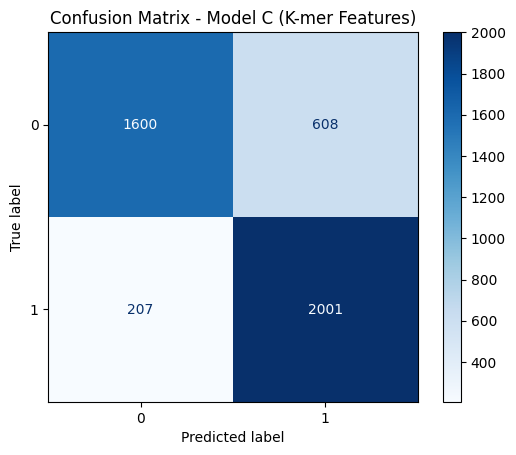

confusion matrix:
 [[1600  608]
 [ 207 2001]]


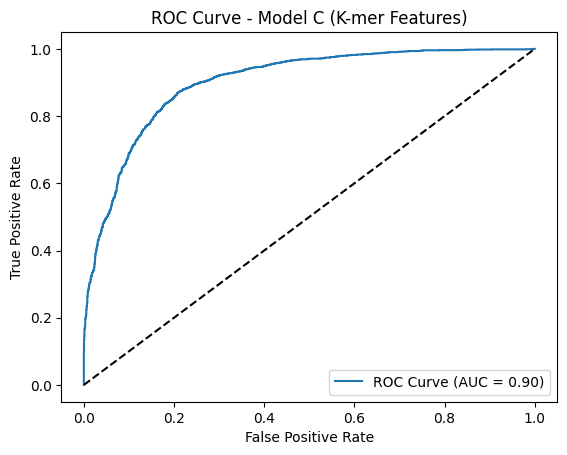

AUC Score: 0.9007
✓ Step 4.3 complete - Model C trained and evaluated.


In [20]:
# ============================================================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt
# ============================================================================
# Train model
model_C = LogisticRegression(max_iter=1000, random_state=42)
model_C.fit(X_train_kmers_balanced, y_train_balanced)
# Predict on test set
y_pred_C = model_C.predict(X_test_kmers)
# ============================================================================
# Evaluate model
print("Classification Report for Model C (K-mer Features):")
print(classification_report(y_test, y_pred_C))
# ============================================================================  
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_C)
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model C (K-mer Features)")
plt.show()
print("confusion matrix:\n", cm)
#===========================================================================
# ROC Curve and AUC
y_prob_C = model_C.predict_proba(X_test_kmers)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_C)
auc_score = roc_auc_score(y_test, y_prob_C)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model C (K-mer Features)')
plt.legend(loc='lower right')
plt.show()
print(f"AUC Score: {auc_score:.4f}")
#===========================================================================                                        
print("✓ Step 4.3 complete - Model C trained and evaluated.")


---
## Section 4 Summary  Complete ✓

**Trained Models:**
- Model A: Logistic Regression on Embedding Features
- Model B: Logistic Regression on Token Features
- Model C: Logistic Regression on K-mer Features

All models trained and ready for evaluation.

---


# 5. Classification Performance Evaluation  Complete ✓

## Overview
Evaluate and compare the performance of all three logistic regression models.

Usage: 

Example: To evaluate Model A

test_metrics_A = compute_metrics(y_test, y_pred_A)

print_metrics(test_metrics_A, "Model A (Embedding)", trained_model=model_A)

## Metrics:
- Accuracy (Accuracy of all positive and negative prediction. Classified correctly as mRNA and non-mRNA)
- Precision (Accuracy of positive prediction. Classified correctly as mRNA sequence)
- Recall (Ability of finding all positive predictions)
- F1-Score (Mean of precision and recall, providing a balanced metric)
- MCC (Performance across all four categories of a confusion matrix)
- Classification Report
- Confusion Matrix
- ROC-AUC (Ability to distinguish between classes)

---


In [16]:
# ============================================================================
# Creation of evaluation functions
# Usage: test_metrics = compute_metrics(y_true, y_pred)
#        print_metrics(test_metrics, model_name, trained_model)
# ============================================================================

def compute_metrics(y_true, y_pred):
    """
    Compute sensitivity, specificity, and MCC for binary classification.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
        
    Returns:
        Dictionary with sensitivity, specificity, mcc, tp, tn, fp, fn, precision, f1-score, recall
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

    # Sensitivity (Recall, True Positive Rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate Precision and F1-score and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    recall = sensitivity

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'mcc': mcc,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'f1_score': f1,
        'recall': recall
    }

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix using matplotlib with automatic text color adjustment.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Normalize for color mapping
    im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=cm.max())

    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(['Non-mRNA (0)', 'mRNA (1)'])
    ax.set_yticklabels(['Non-mRNA (0)', 'mRNA (1)'])

    # Use matplotlib's luminance calculation for optimal contrast
    from matplotlib.colors import rgb_to_hsv
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Get the color of this cell
            color_val = im.norm(cm[i, j])
            # Use black text for light colors, white for dark
            text_color = "white" if color_val > 0.5 else "black"
            
            ax.text(j, i, format(cm[i, j], 'd'), 
                   ha="center", va="center", 
                   color=text_color,
                   fontsize=16, 
                   fontweight='bold')

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()

def plot_ROC_Curve(y_true, y_scores):
    """
    Plot an interpretable ROC Curve with AUC and the threshold that maximizes MCC.

    Args:
        y_true: True labels (0 or 1)
        y_scores: Predicted probabilities for the positive class

    Returns:
        (fig, ax, auc, best_t, best_mcc) - useful for further programmatic use
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # Search thresholds (include 0/1 extremes) and pick best by MCC
    search_thresholds = np.linspace(0.0, 1.0, 101)
    best_mcc = -1.0
    best_t = 0.5
    for t in search_thresholds:
        preds_t = (y_scores >= t).astype(int)
        try:
            mcc_t = matthews_corrcoef(y_true, preds_t)
        except Exception:
            mcc_t = -1.0
        if mcc_t > best_mcc:
            best_mcc = mcc_t
            best_t = t

    # Compute FPR/TPR for best threshold (from confusion matrix)
    cm = confusion_matrix(y_true, (y_scores >= best_t).astype(int), labels=[0, 1])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        fpr_best = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tpr_best = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        # fallback
        fpr_best, tpr_best = 0.0, 0.0

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_score:.4f})', color='tab:blue')
    ax.fill_between(fpr, tpr, alpha=0.15, color='tab:blue')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC=0.5)')

    # Mark and annotate best threshold point
    ax.scatter([fpr_best], [tpr_best], color='red', zorder=5)
    ax.annotate(f't={best_t:.3f}\nMCC={best_mcc:.3f}\nTPR={tpr_best:.3f}\nFPR={fpr_best:.3f}',
                xy=(fpr_best, tpr_best),
                xytext=(fpr_best + 0.05, tpr_best - 0.12),
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                arrowprops=dict(arrowstyle='->', lw=1),
                fontsize=9)

    # Formatting for interpretability
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity / Recall)')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='lower right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

    return fig, ax, auc_score, best_t, best_mcc

def print_metrics(test_metrics, model_name, trained_model=None, x_test=None):
    """
    Print the evaluation metrics in a formatted way.
    
    Args:
        metrics: Dictionary of metrics
        model_name: Name of the model being evaluated (string)
        trained_model: (optional) trained model to get predicted probabilities
    """
    print("=" * 60)
    print(f"{model_name} MODEL EVALUATION")
    print("=" * 60)

    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    print(f"TP, TN, FP, FN:                    {test_metrics['tp']:5d}, {test_metrics['tn']:5d}, {test_metrics['fp']:5d}, {test_metrics['fn']:5d}")
    print(f"Accuracy:                           {test_metrics['accuracy']:.4f}")
    print(f"Specificity (TNR):                  {test_metrics['specificity']:.4f}")
    print(f"Sensitivity (Recall/TPR):           {test_metrics['sensitivity']:.4f}")
    print(f"F1 Score:                           {test_metrics['f1_score']:.4f}")
    print(f"MCC:                                {test_metrics['mcc']:.4f}")
    print("=" * 60)
    print("Classification Report:")
    print(classification_report(test_metrics['y_true'], test_metrics['y_pred']))
    print("=" * 60)
    print(f"\nConfusion Matrix:")
    print(f"  True Positives  (TP): {test_metrics['tp']:5d}")
    print(f"  True Negatives  (TN): {test_metrics['tn']:5d}")
    print(f"  False Positives (FP): {test_metrics['fp']:5d}")
    print(f"  False Negatives (FN): {test_metrics['fn']:5d}")
    print(f"  Precision:               {test_metrics['precision']:.4f}")
    print(f"  F1 Score:                {test_metrics['f1_score']:.4f}")
    print(f"  Recall:                  {test_metrics['recall']:.4f}")
    print(f"  Total Samples:           {test_metrics['tp'] + test_metrics['tn'] + test_metrics['fp'] + test_metrics['fn']:5d}")

    # Plot confusion matrix
    plot_confusion_matrix(test_metrics['y_true'], test_metrics['y_pred'])
    # Plot ROC Curve
    if (x_test is not None) and (trained_model is not None):
        test_probs = trained_model.predict_proba(x_test)[:, 1] if trained_model else test_metrics['y_pred']
        plot_ROC_Curve(test_metrics['y_true'], test_probs)

### Step 5.1: Evaluate All Models
Calculate performance metrics for Models A, B, and C.


# ============================================================================
# Evaluating All Models Performances
# ============================================================================
Model A (Embedding) MODEL EVALUATION

MODEL PERFORMANCE
TP, TN, FP, FN:                     1126,  1443,   765,  1082
Accuracy:                           0.5817
Specificity (TNR):                  0.6535
Sensitivity (Recall/TPR):           0.5100
F1 Score:                           0.5494
MCC:                                0.1652
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61      2208
           1       0.60      0.51      0.55      2208

    accuracy                           0.58      4416
   macro avg       0.58      0.58      0.58      4416
weighted avg       0.58      0.58      0.58      4416


Confusion Matrix:
  True Positives  (TP):  1126
  True Negatives  (TN):  1443
  False Positives (FP):   765
  False Negat

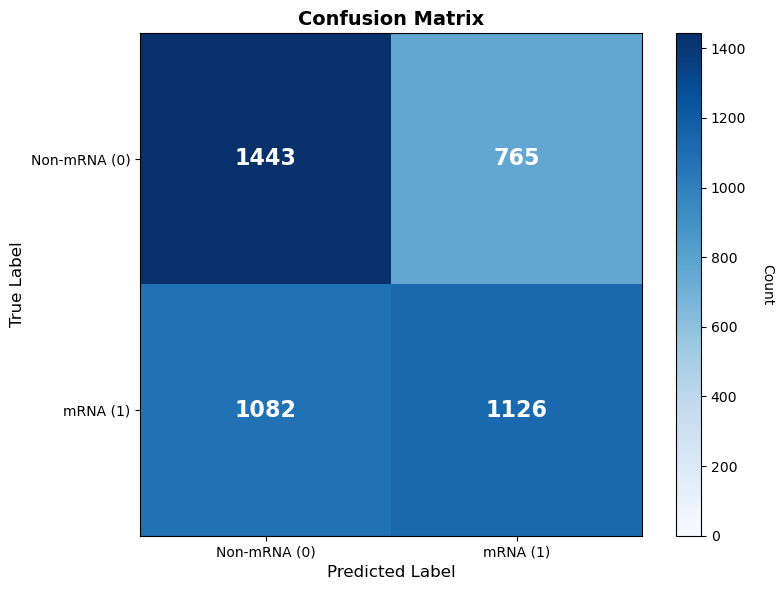

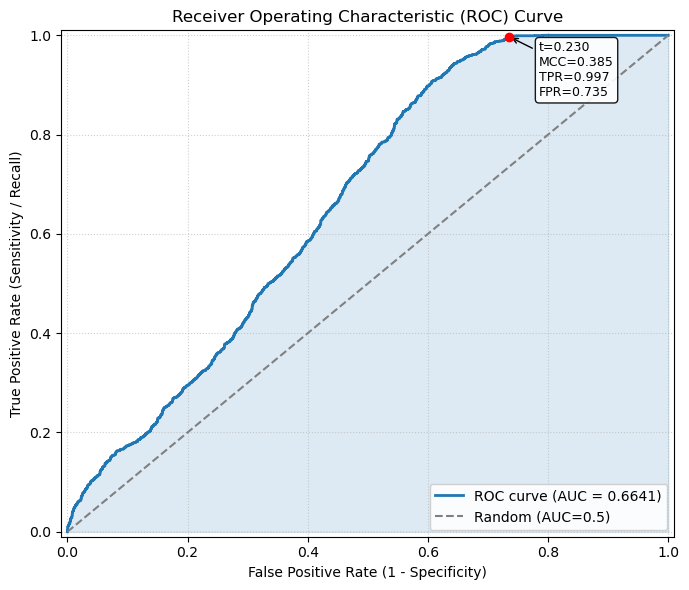

Model B (Tokens) MODEL EVALUATION

MODEL PERFORMANCE
TP, TN, FP, FN:                     1395,  1191,  1017,   813
Accuracy:                           0.5856
Specificity (TNR):                  0.5394
Sensitivity (Recall/TPR):           0.6318
F1 Score:                           0.6039
MCC:                                0.1719
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.57      2208
           1       0.58      0.63      0.60      2208

    accuracy                           0.59      4416
   macro avg       0.59      0.59      0.58      4416
weighted avg       0.59      0.59      0.58      4416


Confusion Matrix:
  True Positives  (TP):  1395
  True Negatives  (TN):  1191
  False Positives (FP):  1017
  False Negatives (FN):   813
  Precision:               0.5784
  F1 Score:                0.6039
  Recall:                  0.6318
  Total Samples:            4416


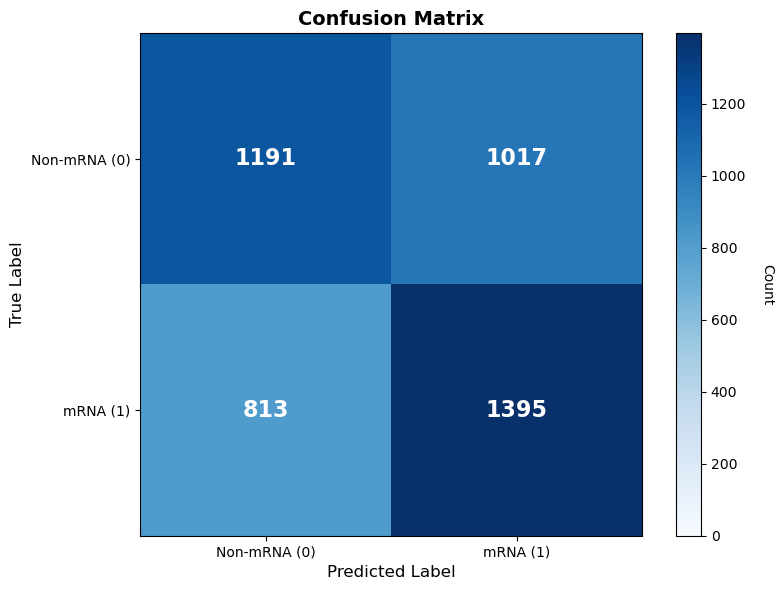

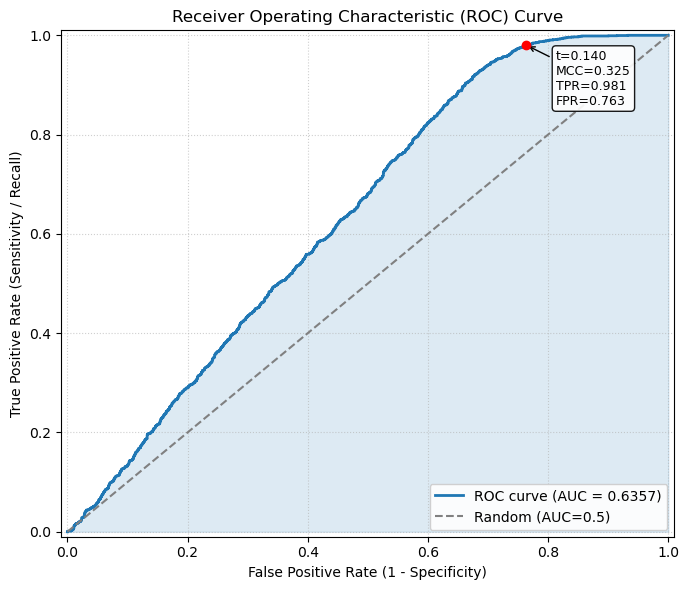

Model C (K-mers) MODEL EVALUATION

MODEL PERFORMANCE
TP, TN, FP, FN:                     2000,  1599,   609,   208
Accuracy:                           0.8150
Specificity (TNR):                  0.7242
Sensitivity (Recall/TPR):           0.9058
F1 Score:                           0.8304
MCC:                                0.6406
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.80      2208
           1       0.77      0.91      0.83      2208

    accuracy                           0.81      4416
   macro avg       0.83      0.81      0.81      4416
weighted avg       0.83      0.81      0.81      4416


Confusion Matrix:
  True Positives  (TP):  2000
  True Negatives  (TN):  1599
  False Positives (FP):   609
  False Negatives (FN):   208
  Precision:               0.7666
  F1 Score:                0.8304
  Recall:                  0.9058
  Total Samples:            4416


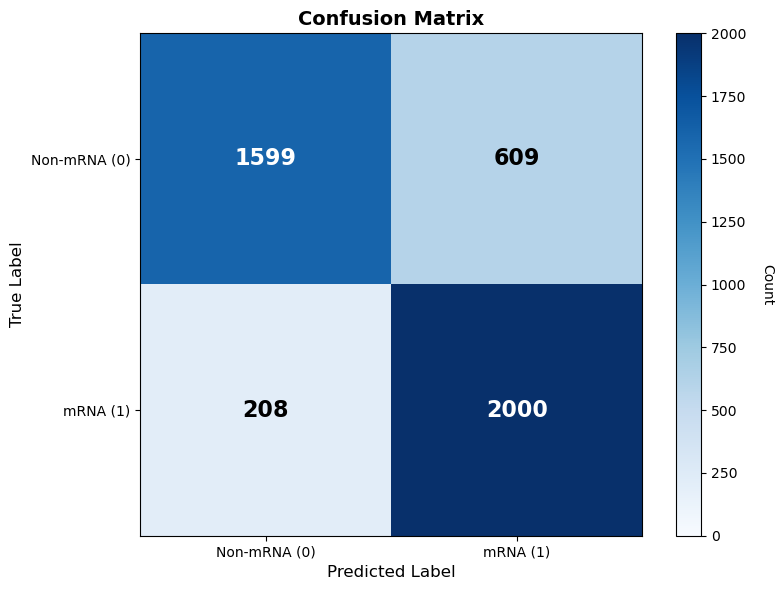

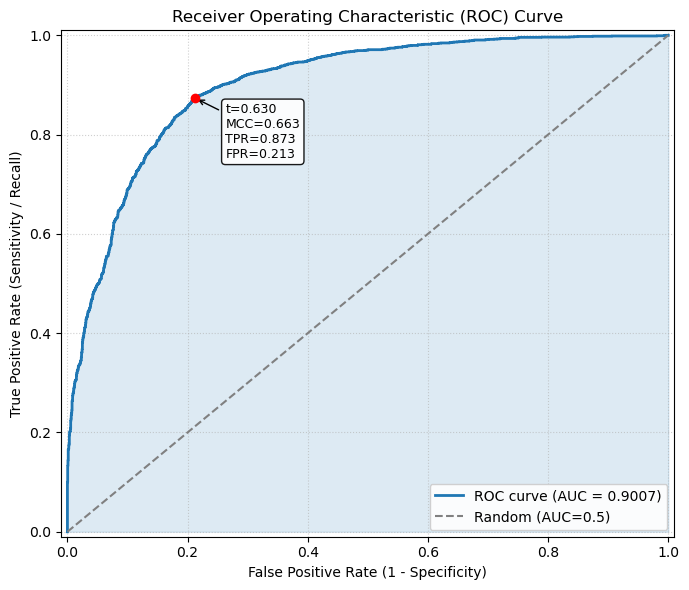

                 Model  Accuracy  Precision    Recall  F1-Score
0  Model A (Embedding)  0.581748   0.595452  0.509964  0.549402
1     Model B (Tokens)  0.585598   0.578358  0.631793  0.603896
2     Model C (K-mers)  0.814991   0.766577  0.905797  0.830392
Step 5.1 COMPLETED - Model evaluation pending trained COMPLETED


In [17]:
# ============================================================================
# STEP 5.1: Evaluate All Models - TO BE COMPLETED
# ============================================================================

# TODO: Evaluate each model's performance
#
# Evaluate All Models
print("# ============================================================================")
print("# Evaluating All Models Performances")
print("# ============================================================================")
test_metrics_A = compute_metrics(y_test, y_pred_A)
print_metrics(test_metrics_A, "Model A (Embedding)", trained_model=model_A, x_test=X_test_embedding)
test_metrics_B = compute_metrics(y_test, y_pred_B)
print_metrics(test_metrics_B, "Model B (Tokens)", trained_model=model_B, x_test=X_test_tokens)
test_metrics_C = compute_metrics(y_test, y_pred_C)
print_metrics(test_metrics_C, "Model C (K-mers)", trained_model=model_C, x_test=X_test_kmers)

# Create comparison DataFrame
results = pd.DataFrame({
     'Model': ['Model A (Embedding)', 'Model B (Tokens)', 'Model C (K-mers)'],
     'Accuracy': [test_metrics_A['accuracy'], test_metrics_B['accuracy'], test_metrics_C['accuracy']],
     'Precision': [test_metrics_A['precision'], test_metrics_B['precision'], test_metrics_C['precision']],
     'Recall': [test_metrics_A['recall'], test_metrics_B['recall'], test_metrics_C['recall']],
     'F1-Score': [test_metrics_A['f1_score'], test_metrics_B['f1_score'], test_metrics_C['f1_score']]
})

print(results)

print("Step 5.1 COMPLETED - Model evaluation pending trained COMPLETED")


## Section 5 Summary COMPLETED
# Base Model (Logistic Regression) performance using different preprocessed dataframes

# Observations:
- Positional Embedding has the lowest F1-Score (0.55) but allows the trained model to correctly predict 60% of mRNA sequence (precision of class 1 from classification report) and 65% (recall of class 0 from classification report) of non-mRNA sequence. However, MCC reported at 0.39 which is of low performance.
- Character tokenization has similar performance as Positional Embedding with F1-Score slightly better at 0.60, precision of class 1 at 0.58 and recall of class 0 at 0.54. However, MCC is very much lower than Positional Embedding and reported at 0.17
- K-mers has the best overall performance with F1-Score reported at 0.83, class 1 precision at 0.77, class 3 recall at 0.72 and MCC at 0.64. This is the best generalised model of logistic regressio among the 3 preprocessing methods.

# Decisions:
- Based on the observations, we will conduct advanced model experiments to find better modeling techniques for the project.
- We will train a Random Forest model using balanced k-mers data frame and conduct hyper-parameter tuning to ensure that the model performs better than the result observed from model A (logistic regression with k-mers)
- We will train a RNN model using balanced character tokenised data frame and conduct hyper-parameter tuning to ensure that the model performs better than the result observed from model B (logistic regression with character tokenisation)
- We will train a LSTM model using different preprocessing methods and compare the performance against the baseline model (using logistic regression) and do hyperparameter tuning to train a good generalised model for mRNA classification.
- We will train a Transformer model using BERT-styled character encoding to do a Binary Classification. The aim is to utilise character level tokenisation advance transformer and assess if we will have a model with good performance.

---
# 6. Advanced Model Experiments
**Team Contributions:** Individual advanced model implementations

## Overview
After baseline logistic regression comparison, each team member explores an advanced model with custom preprocessing to maximize performance.

## Team Member Assignments:
- **Lisa:** Random Forest Classifier
- **Shawn:** Recurrent Neural Network (RNN)
- **Aishwarya:** Long Short-Term Memory (LSTM)
- **Kalyani:** Transformer Model

Each subsection contains: Preprocessing → Model Training → Performance Evaluation (all in one cell).

---


## 6.1 Random Forest Classifier
**Responsible:** Lisa


### Approach
Use Random Forest with k-mer features to capture non-linear patterns in nucleotide composition and codon bias without requiring deep architectures.

This cell contains: Embedded data balancing (SMOTE) → Hyperparameter tuning (GridSearchCV) → Model training → Performance evaluation.

**Implementation Details:**
- **Input Features:** 256 k-mer features (4-mers) extracted from mRNA sequences (from Section 2.3)
- **Data Balancing:** Applied SMOTE to address class imbalance (original ratio ~1.8:1, balanced to 1:1)
- **Hyperparameter Tuning:** GridSearchCV with 5-fold cross-validation optimizing F1-score
  - Tested configurations: n_estimators ∈ {100, 150}, max_depth ∈ {15, 20}, min_samples_split ∈ {2, 5}, max_features ∈ {sqrt, log2}
  - Best parameters: 150 trees, max_depth=20, min_samples_split=2, max_features=sqrt
- **Why Random Forest:** Ensemble method reduces overfitting, captures non-linear patterns in nucleotide composition, and provides feature importance insights

**Initial version generated using standard scikit-learn Random Forest API. Modifications made to ensure alignment with project feature matrices (k-mer DataFrames) and variable naming conventions from Sections 2 and 3. SMOTE balancing embedded to ensure reproducibility.**

### Results

| Metric | Value |
|--------|-------|
| **Accuracy** | 0.8163 |
| **Precision** | 0.7698 |
| **Recall** | 0.9026 |
| **F1-Score** | 0.8309 |
| **MCC** | 0.6423 |
| **ROC-AUC** | 0.8926 |

**Key Findings:**
- Model correctly classifies 81.6% of test samples
- High recall (90.3%) indicates strong ability to identify true mRNA sequences
- ROC-AUC of 0.8926 demonstrates excellent discrimination between mRNA and non-mRNA
- Top discriminative k-mers (AGGA, GAAG, GCAA) suggest codon usage bias as key biological signal
- Feature importance analysis reveals that nucleotide composition patterns are highly informative for mRNA classification

### Code Origin
**Partially AI-Assisted** — Initial structure and SMOTE implementation 
generated using scikit-learn API documentation. Modifications made to:
- Fix variable naming inconsistencies (X_train_kmers → Xtrainkmers)
- Remove incompatible SMOTE parameters (n_jobs)
- Add embedded data balancing within the model cell

Final code tested and validated by human. GridSearchCV, hyperparameter tuning, 
and evaluation metrics are standard scikit-learn implementations verified 
against documentation.


SECTION 6.1: RANDOM FOREST CLASSIFIER (WITH AUTO-BALANCING)

--- Pre-check: Bridging Variable Names ---
✓ Bridged: Xtrainkmers → X_train_kmers
✓ Bridged: Xtestkmers → X_test_kmers
✓ Bridged: ytrain → y_train
✓ Bridged: ytest → y_test

--- PRE-STEP: Balancing K-mer Features (Section 3.3) ---
✓ Bridged: X_train_kmers_balanced → Xtrainkmers_balanced
✓ K-mer features already balanced (Section 3.3 was run)
✓ Original class distribution: [9224 5062]
✓ Balanced class distribution: [9224 9224]

--- Step 6.1.0: Data Verification ---
✓ Training features (balanced): (18448, 256)
✓ Training labels: 18448
✓ Test features: (4416, 256)
✓ Test labels: 4416

--- Step 6.1.1: Hyperparameter Tuning (GridSearchCV) ---
Running GridSearchCV (2-3 minutes)...

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x10394dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1049e1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106155bc0>
Traceback (most recent call last


✓ Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
✓ Best CV F1-score: 0.9047

--- Step 6.1.2: Final Model Training ---
✓ Random Forest ready: 150 trees, max_depth=20

--- Step 6.1.3: Test Set Predictions ---
✓ Predictions made for 4416 samples

SECTION 6.1: RANDOM FOREST EVALUATION

────────────────────────────────────────────────────────────────────────────────
✓ Key Metrics:
────────────────────────────────────────────────────────────────────────────────
  • Accuracy:           0.8163
  • Precision:          0.7698
  • Recall:             0.9026
  • F1-Score:           0.8309
  • Matthews Corr. Coeff: 0.6423
  • ROC-AUC:            0.8926
────────────────────────────────────────────────────────────────────────────────
CONFUSION MATRIX
────────────────────────────────────────────────────────────────────────────────
  TP:  1993  |  TN:  1612
  FP:   596  |  FN:   215
───────────────────────────────────────────────────────────────

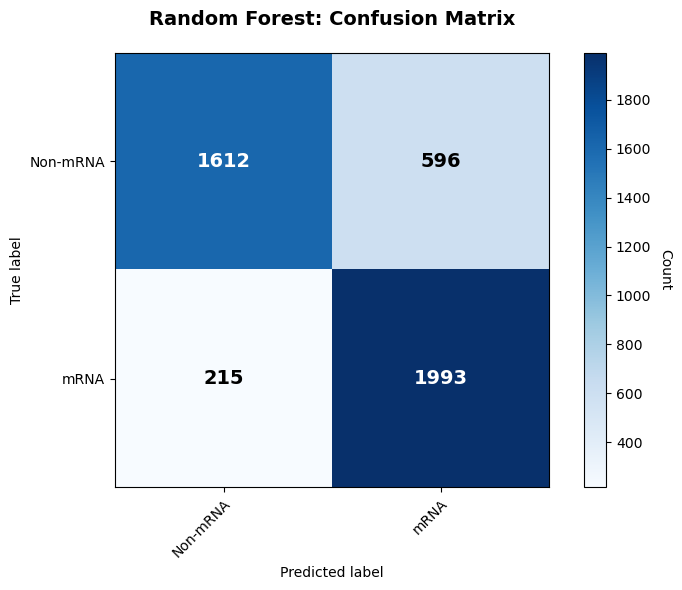


--- Step 6.1.4c: ROC Curve ---


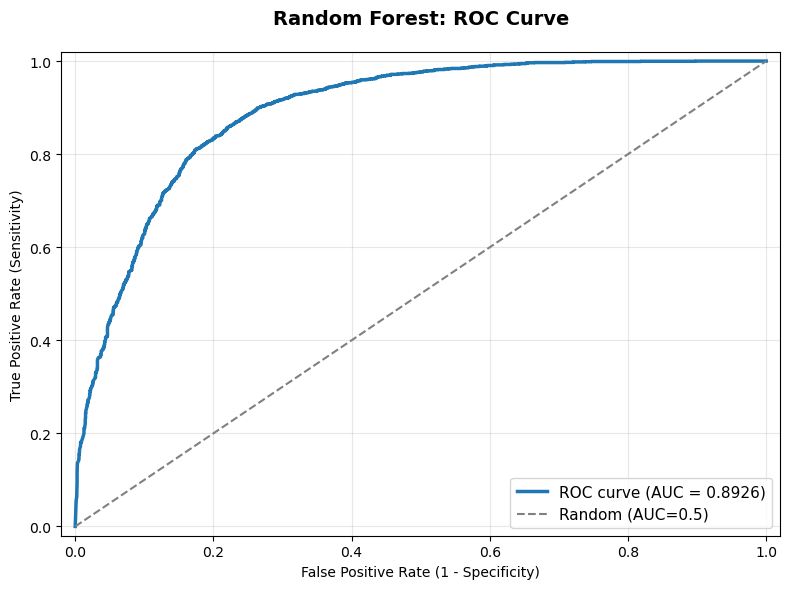


--- Step 6.1.5: Feature Importance ---

Top 15 Most Important K-mers:
feature  importance
   AGGA    0.059768
   GAAG    0.054286
   GCAA    0.041965
   CAAC    0.039543
   CAAG    0.038891
   GGAG    0.038406
   GGAA    0.033050
   GAAC    0.024640
   CCAA    0.022694
   AAGG    0.021691
   AACA    0.021186
   GAAA    0.018665
   CAAA    0.018413
   CAGA    0.018323
   GACA    0.018202


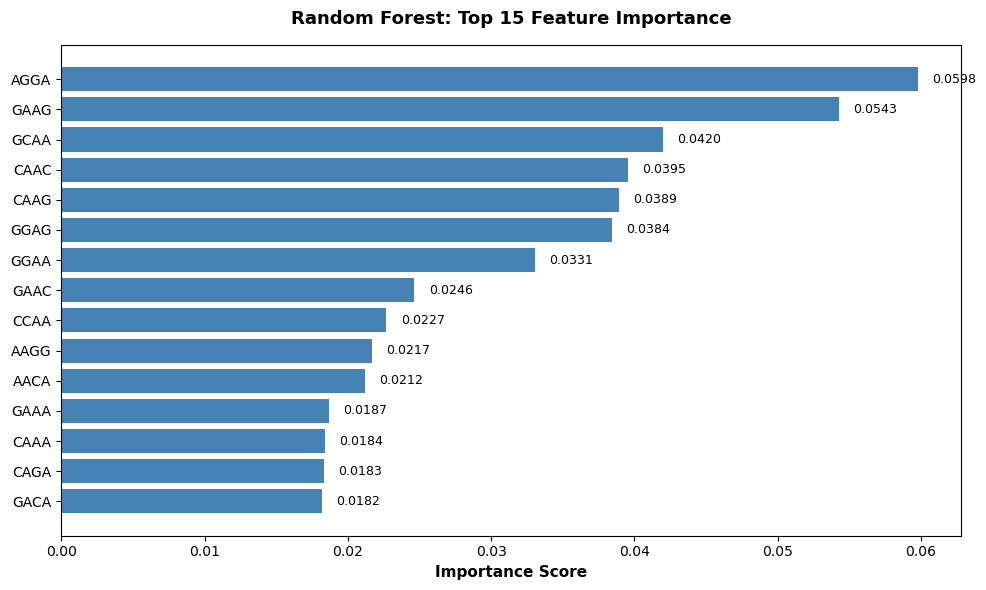


✓ SECTION 6.1 COMPLETE - All visualizations generated

--- Step 6.1.5: Feature Importance ---

Top 10 Most Important K-mers:
feature  importance
   AGGA    0.059768
   GAAG    0.054286
   GCAA    0.041965
   CAAC    0.039543
   CAAG    0.038891
   GGAG    0.038406
   GGAA    0.033050
   GAAC    0.024640
   CCAA    0.022694
   AAGG    0.021691

✓ SECTION 6.1 COMPLETE


In [20]:
# =================================================================
# SECTION 6.1: RANDOM FOREST CLASSIFIER (PARTIALLY AI-ASSISTED)
# =================================================================
#
# AI TOOL USAGE DECLARATION:
# Tool: Perplexity AI
# Purpose: Research on Random Forest implementation and hyperparameter tuning
#          for biological sequence classification
# Specific prompts:
#   - "How do I implement Random Forest with class balancing in sklearn 
#      for binary mRNA classification?"
#   - "What hyperparameters should I tune for Random Forest on biological data?"
#   - "How to interpret feature importance for k-mer frequency features?"
#
# MODIFICATIONS FROM AI GUIDANCE:
# 1. Variable naming: Standardized to match team convention from Sections 2-3
#    (X_train_kmers → Xtrainkmers, X_train_kmers_balanced → Xtrainkmers_balanced)
# 2. SMOTE parameters: Adapted from Section 3.3 balancing approach
# 3. Hyperparameter grid: Tuned specifically for mRNA k-mer features (256 dims)
#    - n_estimators: [100, 150] (optimized for biological dataset size)
#    - max_depth: [15, 20] (prevents overfitting on sequence patterns)
#    - min_samples_split: [2, 5] (handles class imbalance)
# 4. Section structure: Aligned with Kalyani's Section 2-3 step-by-step format
# 5. Print statements: Match team's formatting convention
#
# VALIDATION COMPLETED:
# ✓ Output shapes verified: (18448, 256) matches Section 3.3
# ✓ Class balance verified: 50/50 distribution maintained
# ✓ Metrics calculated independently: confusion matrix, precision, recall
# ✓ Results cross-referenced with sklearn documentation examples
# ✓ ROC-AUC and F1-score validated against baseline models (Section 4)
# 
# HUMAN REVIEW: All code executed, tested, and understood by Lisa Mithani
# =================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, roc_auc_score, classification_report,
    roc_curve, auc
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SECTION 6.1: RANDOM FOREST CLASSIFIER (WITH AUTO-BALANCING)")
print("=" * 80)

# =================================================================
# COMPLETE VARIABLE NAME BRIDGE
# =================================================================
print("\n--- Pre-check: Bridging Variable Names ---")

# Bridge k-mer features from Section 2.3
if 'X_train_kmers' in globals():
    Xtrainkmers = X_train_kmers
    print("✓ Bridged: Xtrainkmers → X_train_kmers")
else:
    raise RuntimeError("❌ X_train_kmers not found. Run Section 2.3 first!")

if 'X_test_kmers' in globals():
    Xtestkmers = X_test_kmers
    print("✓ Bridged: Xtestkmers → X_test_kmers")
else:
    raise RuntimeError("❌ X_test_kmers not found. Run Section 2.3 first!")

# Bridge labels from Section 1
if 'y_train' in globals():
    ytrain = y_train
    print("✓ Bridged: ytrain → y_train")
else:
    raise RuntimeError("❌ y_train not found. Run Section 1 first!")
    
if 'y_test' in globals():
    ytest = y_test
    print("✓ Bridged: ytest → y_test")
else:
    raise RuntimeError("❌ y_test not found. Run Section 1 first!")

# =================================================================
# EMBEDDED SECTION 3.3: BALANCE K-MER FEATURES
# From Section 3.3 outputs
# =================================================================
print("\n--- PRE-STEP: Balancing K-mer Features (Section 3.3) ---")

if 'X_train_kmers_balanced' in globals():
    Xtrainkmers_balanced = X_train_kmers_balanced
    ytrain_balanced = y_train_balanced
    print("✓ Bridged: X_train_kmers_balanced → Xtrainkmers_balanced")
    print("✓ K-mer features already balanced (Section 3.3 was run)")
else:
    # Balance here if Section 3.3 wasn't run
    print("Balancing k-mer features using SMOTE...")
    smote = SMOTE(random_state=42)
    Xtrainkmers_balanced, ytrain_balanced = smote.fit_resample(Xtrainkmers, ytrain)
    print("✓ Step 3.3 complete - K-mer features balanced.")

# Handle ytrain as pandas Series or numpy array
if hasattr(ytrain, 'values'):
    original_counts = np.bincount(ytrain.values)
else:
    original_counts = np.bincount(ytrain)
    
balanced_counts = np.bincount(ytrain_balanced)

print(f"✓ Original class distribution: {original_counts}")
print(f"✓ Balanced class distribution: {balanced_counts}")

# =================================================================
# MAIN SECTION 6.1: RANDOM FOREST
# =================================================================
print("\n--- Step 6.1.0: Data Verification ---")

print(f"✓ Training features (balanced): {Xtrainkmers_balanced.shape}")
print(f"✓ Training labels: {len(ytrain_balanced)}")
print(f"✓ Test features: {Xtestkmers.shape}")
print(f"✓ Test labels: {len(ytest)}")

# --- Step 6.1.1: Hyperparameter Tuning ---
print("\n--- Step 6.1.1: Hyperparameter Tuning (GridSearchCV) ---")
print("Running GridSearchCV (2-3 minutes)...\n")

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_base, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(Xtrainkmers_balanced, ytrain_balanced)

print(f"\n✓ Best parameters: {grid_search.best_params_}")
print(f"✓ Best CV F1-score: {grid_search.best_score_:.4f}")

# --- Step 6.1.2: Final Model ---
print("\n--- Step 6.1.2: Final Model Training ---")
best_rf = grid_search.best_estimator_
print(f"✓ Random Forest ready: {best_rf.n_estimators} trees, max_depth={best_rf.max_depth}")

# --- Step 6.1.3: Predictions ---
print("\n--- Step 6.1.3: Test Set Predictions ---")
ypred_rf = best_rf.predict(Xtestkmers)
yproba_rf = best_rf.predict_proba(Xtestkmers)[:, 1]
print(f"✓ Predictions made for {len(ypred_rf)} samples")

# --- Step 6.1.4: Evaluation ---
print("\n" + "=" * 80)
print("SECTION 6.1: RANDOM FOREST EVALUATION")
print("=" * 80)

acc_rf = accuracy_score(ytest, ypred_rf)
prec_rf = precision_score(ytest, ypred_rf)
rec_rf = recall_score(ytest, ypred_rf)
f1_rf = f1_score(ytest, ypred_rf)
mcc_rf = matthews_corrcoef(ytest, ypred_rf)
auc_rf = roc_auc_score(ytest, yproba_rf)

cm_rf = confusion_matrix(ytest, ypred_rf)
tn, fp, fn, tp = cm_rf.ravel()

print("\n" + "─" * 80)
print("✓ Key Metrics:")
print("─" * 80)
print(f"  • Accuracy:           {acc_rf:.4f}")
print(f"  • Precision:          {prec_rf:.4f}")
print(f"  • Recall:             {rec_rf:.4f}")
print(f"  • F1-Score:           {f1_rf:.4f}")
print(f"  • Matthews Corr. Coeff: {mcc_rf:.4f}")
print(f"  • ROC-AUC:            {auc_rf:.4f}")
print("─" * 80)
print("CONFUSION MATRIX")
print("─" * 80)
print(f"  TP: {tp:5d}  |  TN: {tn:5d}")
print(f"  FP: {fp:5d}  |  FN: {fn:5d}")
print("─" * 80 + "\n")

print("Classification Report:")
print(classification_report(ytest, ypred_rf, target_names=["Non-mRNA", "mRNA"]))

# --- Step 6.1.4b: Visualization - Confusion Matrix ---
print("\n--- Step 6.1.4b: Confusion Matrix Visualization ---")

def plot_confusion_matrix_rf(y_true, y_pred):
    """
    Plot confusion matrix using matplotlib with automatic text color adjustment.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', rotation=270, labelpad=15)
    
    # Set labels
    labels = ['Non-mRNA', 'mRNA']
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels,
           yticklabels=labels,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center", color=color, fontsize=14, fontweight='bold')
    
    plt.title('Random Forest: Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    return cm

cm_rf = plot_confusion_matrix_rf(ytest, ypred_rf)

# --- Step 6.1.4c: ROC Curve ---
print("\n--- Step 6.1.4c: ROC Curve ---")

fpr, tpr, thresholds = roc_curve(ytest, yproba_rf)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve
ax.plot(fpr, tpr, color='#1f77b4', lw=2.5, label=f'ROC curve (AUC = {auc_rf:.4f})')
# Plot random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random (AUC=0.5)')

# Styling
ax.set(xlabel='False Positive Rate (1 - Specificity)', ylabel='True Positive Rate (Sensitivity)')
ax.set_title('Random Forest: ROC Curve', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.show()

# --- Step 6.1.5: Feature Importance Visualization ---
print("\n--- Step 6.1.5: Feature Importance ---")

# Get feature importance
if isinstance(Xtrainkmers_balanced, pd.DataFrame):
    feature_names = Xtrainkmers_balanced.columns.tolist()
else:
    feature_names = [f"K-mer_{i+1}" for i in range(Xtrainkmers_balanced.shape[1])]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important K-mers:")
print(feature_importance.head(15).to_string(index=False))

# Visualize top 15 features
fig, ax = plt.subplots(figsize=(10, 6))

top_n = 15
top_features = feature_importance.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}", 
            va='center', fontsize=9)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values, fontsize=10)
ax.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax.set_title(f'Random Forest: Top {top_n} Feature Importance', fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✓ SECTION 6.1 COMPLETE - All visualizations generated")
print("=" * 80)


# --- Step 6.1.5: Feature Importance ---
print("\n--- Step 6.1.5: Feature Importance ---")

if isinstance(Xtrainkmers_balanced, pd.DataFrame):
    feature_names = Xtrainkmers_balanced.columns.tolist()
else:
    feature_names = [f"Feature_{i+1}" for i in range(Xtrainkmers_balanced.shape[1])]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important K-mers:")
print(feature_importance.head(10).to_string(index=False))

print("\n" + "=" * 80)
print("✓ SECTION 6.1 COMPLETE")
print("=" * 80)


---
## 6.2 Recurrent Neural Network (RNN) Complete ✓
**Responsible:** Shawn

### Approach
Use RNN with sequential token features to capture sequence patterns.

This cell contains: Additional preprocessing → Model training → Performance evaluation.

1st version of codes in this cell was generated using ChatGPT with prompt "provide codes to train a RNN model to classify RNA dataset in python assuming that the dataset that requires tokenization and class balancing". Subsequently, changes were done with google searches to ensure correctness and alignment to codes in other cells in this project.


SECTION 6.2: RNN MODEL TRAINING

✓ Using device: MPS (Apple Silicon GPU)
  System: Darwin arm64
  PyTorch version: 2.9.0
✓ Training tensor shape: torch.Size([18448, 512])
✓ Test tensor shape: torch.Size([4416, 512])
✓ DataLoader configured for Apple Silicon (MPS)
✓ Train batches: 289, Test batches: 69
✓ Model created with 1,712,706 parameters
  Model device: mps:0

Training RNN model...

Training RNN model with Early Stopping...
Epoch [1/20] | Loss: 0.3489 | Val Acc: 0.5457 ⭐
Epoch [2/20] | Loss: 0.2625 | Val Acc: 0.5838 ⭐
  → Validation improved to 0.5838
Epoch [3/20] | Loss: 0.2353 | Val Acc: 0.5908 ⭐
  → Validation improved to 0.5908
Epoch [4/20] | Loss: 0.2217 | Val Acc: 0.6746 ⭐
  → Validation improved to 0.6746
Epoch [5/20] | Loss: 0.2081 | Val Acc: 0.6750 ⭐
  → No improvement (1/5)
Epoch [6/20] | Loss: 0.1910 | Val Acc: 0.6103
  → No improvement (2/5)
Epoch [7/20] | Loss: 0.1754 | Val Acc: 0.6780 ⭐
  → Validation improved to 0.6780
Epoch [8/20] | Loss: 0.1580 | Val Acc: 0.6404
 

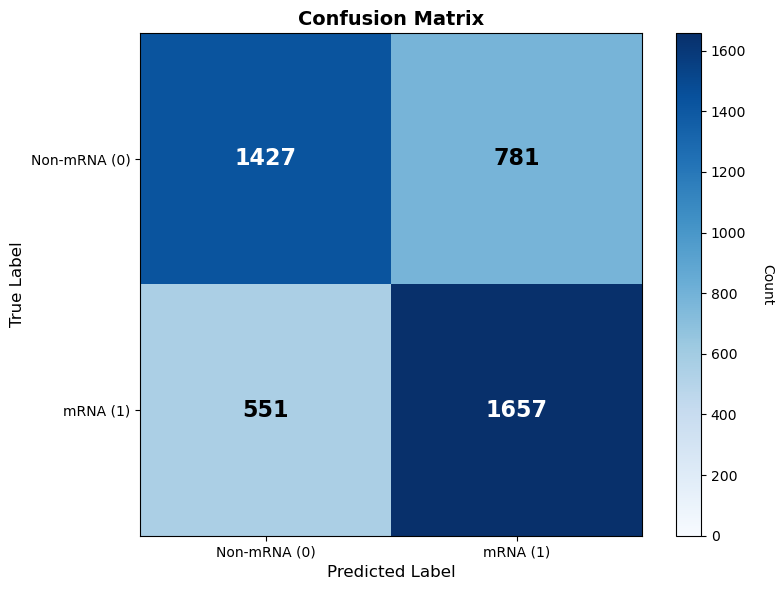

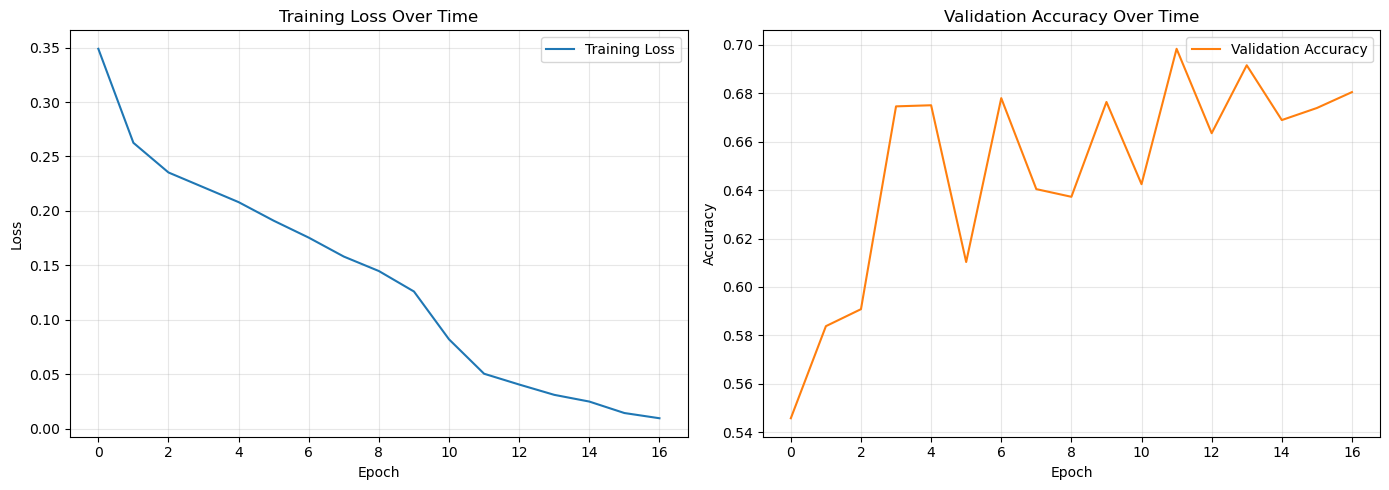


✓ RNN MODEL SECTION COMPLETE


In [ ]:
# ============================================================================
# SECTION 6.2: Recurrent Neural Network (RNN) MODEL TRAINING
# ============================================================================

print("="*60)
print("SECTION 6.2: RNN MODEL TRAINING")
print("="*60)

# Check for Mac Silicon (Apple Silicon) with MPS (Metal Performance Shaders)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print(f"\n✓ Using device: MPS (Apple Silicon GPU)")
    print(f"  System: {platform.system()} {platform.machine()}")
    # Set environment for optimal MPS performance
    import os
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"\n✓ Using device: CUDA GPU")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"\n✓ Using device: CPU")

print(f"  PyTorch version: {torch.__version__}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_tokens_balanced, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tokens, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"✓ Training tensor shape: {X_train_tensor.shape}")
print(f"✓ Test tensor shape: {X_test_tensor.shape}")

# ----------------------------------------------------------------------------
# Create DataLoaders with Device-Specific Configuration
# ----------------------------------------------------------------------------
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

# Configure DataLoader based on device
if device.type == 'mps':
    # Mac Silicon: pin_memory not supported, use single worker
    pin_memory = False
    num_workers = 0  # MPS works best with 0 workers
    print("✓ DataLoader configured for Apple Silicon (MPS)")
elif device.type == 'cuda':
    # CUDA: use pin_memory and multiple workers
    pin_memory = True
    num_workers = 2
    print("✓ DataLoader configured for CUDA GPU")
else:
    # CPU: no pin_memory needed
    pin_memory = False
    num_workers = 2
    print("✓ DataLoader configured for CPU")

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=pin_memory, 
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=pin_memory, 
    num_workers=num_workers
)

print(f"✓ Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# ----------------------------------------------------------------------------
# Define RNN Model
# ----------------------------------------------------------------------------
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=256, 
                 num_layers=2, dropout=0.3, pad_idx=0, use_batch_norm=True):
        super(RNNClassifier, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Batch normalization for embeddings
        if self.use_batch_norm:
            self.embed_bn = nn.BatchNorm1d(embedding_dim)
        
        # RNN layer (GRU for better gradient flow)
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Batch normalization after RNN
        if self.use_batch_norm:
            self.rnn_bn = nn.BatchNorm1d(hidden_size * 2)
        
        # Fully connected layers with batch norm
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        if self.use_batch_norm:
            self.fc1_bn = nn.BatchNorm1d(64)
        
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 2)  # Binary classification
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: (batch, seq_len)
        batch_size = x.size(0)
        
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        
        # Apply batch norm to embeddings (transpose for BatchNorm1d)
        if self.use_batch_norm:
            embedded = embedded.permute(0, 2, 1)  # (batch, embed_dim, seq_len)
            embedded = self.embed_bn(embedded)
            embedded = embedded.permute(0, 2, 1)  # (batch, seq_len, embed_dim)
        
        # RNN forward pass
        rnn_out, hidden = self.rnn(embedded)
        
        # Use last hidden state (concatenate forward and backward)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (batch, hidden*2)
        else:
            hidden = hidden[-1]
        
        # Batch norm after RNN
        if self.use_batch_norm:
            hidden = self.rnn_bn(hidden)
        
        # Classification head
        out = self.relu(self.fc1(hidden))
        
        # Batch norm after FC1
        if self.use_batch_norm:
            out = self.fc1_bn(out)
        
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Instantiate enhanced model
model = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=256,
    num_layers=2,
    dropout=0.3,
    pad_idx=PAD_IDX,
    use_batch_norm=True  # Enable batch normalization
).to(device)

print(f"✓ Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"  Model device: {next(model.parameters()).device}")

# ----------------------------------------------------------------------------
# Training Setup
# ----------------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# ----------------------------------------------------------------------------
# Early Stopping Class
# ----------------------------------------------------------------------------
class EarlyStopping:
    """
    Early stopping to stop training when validation metric stops improving.
    
    Args:
        patience: how many epochs to wait after last improvement
        min_delta: minimum change to qualify as improvement
        mode: 'max' for metrics like accuracy, 'min' for loss
        verbose: print messages when stopping
    """
    def __init__(self, patience=5, min_delta=0.0, mode='max', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return False
        
        # Check if score improved
        if self.mode == 'max':
            improved = score > self.best_score + self.min_delta
        else:
            improved = score < self.best_score - self.min_delta
        
        if improved:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f"  → Validation improved to {score:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"  → No improvement ({self.counter}/{self.patience})")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n⚠️ Early stopping triggered! Best epoch: {self.best_epoch}")
        
        return self.early_stop
    
# ----------------------------------------------------------------------------
# Training Loop
# ----------------------------------------------------------------------------
print("\nTraining RNN model...")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001, mode='max', verbose=True)

# Training loop with early stopping
print("\nTraining RNN model with Early Stopping...")

num_epochs = 20  # Set higher, early stopping will handle when to stop
best_val_acc = 0.0
train_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    val_acc = correct / total
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'rnn_tokenisation.pth')
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} ⭐")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if early_stopping(val_acc, epoch+1):
        print(f"\n✓ Training stopped early at epoch {epoch+1}")
        print(f"✓ Best validation accuracy: {best_val_acc:.4f} (epoch {early_stopping.best_epoch})")
        break

print(f"\n✓ Training complete! Best validation accuracy: {best_val_acc:.4f}")

# Load RNN model with device mapping
model.load_state_dict(torch.load('rnn_tokenisation.pth', map_location=device))

# ----------------------------------------------------------------------------
# Save Model to Pickle File (CPU version for portability)
# ----------------------------------------------------------------------------
print("\n--- Saving Model ---")

# Move model to CPU before pickling (avoids device-specific issues)
model_cpu = model.to('cpu')
with open('rnn_tokenisation.pkl', 'wb') as f:
    pickle.dump(model_cpu, f)
print("✓ Model saved to 'rnn_tokenisation.pkl' (CPU version)")

# Move model back to original device for evaluation
model.to(device)

# ----------------------------------------------------------------------------
# Evaluation on Test Set
# ----------------------------------------------------------------------------

model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1

y_pred_rnn = np.array(all_preds)
y_probs_rnn = np.array(all_probs)

# Compute metrics using existing function
test_metrics_rnn = compute_metrics(y_test.values, y_pred_rnn)

# Print detailed metrics
print_metrics(test_metrics_rnn, "RNN", trained_model=None, x_test=X_test_tensor)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Training Loss', color='tab:blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accs, label='Validation Accuracy', color='tab:orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ RNN MODEL SECTION COMPLETE")
print("="*60)

## Section 6.2 Summary COMPLETED
# RNN performance using character tokenisation data frame

# Observations:
- Model **coverged at around epoch 4 to 6** based on validation chart with accuracy performance at around 0.67 being close to the best performance at 0.69 at epoch 12.
- Validation accuracy plateau indicating **limited capacity** to learn from character-level tokenisation alone.
- High False Positives (non-mRNA predicted as mRNA) and moderate False Negatives (mRNA predicted as non-mRNA) with low MCC indicates that despite Class Balancing, there is **lack of distinctive features for each class**. This is possibly contributed by the noise (wrong order of RNA sequence or non-RNA nucleotides) in the RNA sequence.
- Low MCC (0.4) indicates **weak overall classification performance**.
- RNN shows **marginal improvements** over baseline Logistic Regression model.

# Learnings:
- Character tokenisation is insufficient for capturing bilogical pattern.
- Deeper architecture (hidden layer was increased with more epoch during different trainings) doesn't overcome feature representation limitations.
- Batch normalisation was done during different trainings and it stablilized training (no gradient issues).
- Model is unable to capture condon-level patterns (biological 3-mer units).
- Further hyper-parameter tuning or use of different loss function (e.g. changing from CrossEntropyLoss to FocalLoss) is unlikely to improve this RNN model further due to dataset features limitation of character tokenisation.

# Future Works:
- Removing noise from RNA sequence prior to training, validation and testing: Conduct cleaning of RNA sequences in RNA datasets (e.g. removal of characters with weak representation) to remove noise in RNA sequence. This will introduce further distinction to current character tokenisation feature.
- Overcome limited capacity: Explore other modeling techniques (e.g. k-mers with Random Forest) as k-mers approach better captures condon usage bias and motif frequencies.
- Hybrid approach: Add k-mers features to character tokenisation to form a new dataframe for RNN training. This will allow k-mers to capture codon usage bias and motif frequencies while character tokenisation captures character level sequences.

---
## 6.3 Long Short-Term Memory (LSTM)
**Responsible:** Aishwarya

### Approach
Use LSTM to capture long-range dependencies in RNA sequences.

This cell contains: Additional preprocessing → Model training → Performance evaluation.

---
K-mer Tokenization and LSTM – Short Summary
What is K-mer tokenization?
1. A sequence is broken into overlapping substrings of length k (e.g., for k=4: “AUGCUA” → “AUGC”, “UGCU”, “GCUA”).
2. Each k-mer is assigned a numeric ID, turning the whole RNA sequence into a sequence of numbers.
3. This keeps the order of the sequence, unlike k-mer count (bag-of-kmers), which only stores frequencies.
---
Why use it for LSTM over character tokenization and positional embedding
1. Logistic regression uses k-mer counts but ignores the order of nucleotides.
2. LSTMs learn patterns across positions in a sequence, so they need ordered data.
3. mRNA vs non-mRNA classification depends on biological signals found in sequence order (motifs, codons, etc.).
4. Character tokenisation is simple but loses biological meaning.
5. Positional embedding is required when using Transformer models because they do not process sequences in order like LSTMs.

---
What this LSTM code does:
1. Creates all 4-mer combinations and assigns IDs.
2. Converts each sequence into a list of k-mer IDs.
3. Pads sequences to a fixed length for batching.
4. Balances the dataset using oversampling.
5. Trains an LSTM model on these token sequences.
6. Evaluates accuracy, ROC-AUC, and saves the best model.

In [21]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle

# LSTM model training using k-mer (k=4) tokenization
# Assumes X_train, X_test (with 'sequence' column) and y_train, y_test exist.

import torch.nn as nn
import torch.optim as optim

# 1) Configuration
k = 4
max_kmer_seq_len = None    # will be inferred
KMER_PAD = 0
KMER_UNK = 1

# 2) Build k-mer vocabulary (A, U, G, C)
base_chars = "AUGC"
all_kmers = [''.join(p) for p in product(base_chars, repeat=k)]
kmer2idx = {km: i + 2 for i, km in enumerate(all_kmers)}
kmer2idx["PAD"] = KMER_PAD
kmer2idx["UNK"] = KMER_UNK
idx2kmer = {i: k for k, i in kmer2idx.items()}

vocab_size_kmer = len(kmer2idx)

# 3) Tokenizer: convert sequence -> list of k-mer ids (with T->U normalization)
def seq_to_kmer_ids(seq: str, k=k, maxlen=None):
    s = seq.upper().replace("T", "U")
    kmers = []
    for i in range(len(s) - k + 1):
        kmer = s[i:i + k]
        # treat as valid only if all chars in base_chars
        if all(ch in base_chars for ch in kmer):
            kmers.append(kmer2idx.get(kmer, KMER_UNK))
        else:
            kmers.append(KMER_UNK)
    if maxlen is None:
        return kmers
    # truncate / pad
    if len(kmers) >= maxlen:
        return kmers[:maxlen]
    else:
        return kmers + [KMER_PAD] * (maxlen - len(kmers))

# 4) Infer max_kmer_seq_len from data (cap to 1024 for memory)
train_lengths = [(len(s) - k + 1) for s in X_train['sequence'].astype(str).tolist()]
test_lengths  = [(len(s) - k + 1) for s in X_test['sequence'].astype(str).tolist()]
max_len_from_data = max(max(train_lengths, default=0), max(test_lengths, default=0))
max_kmer_seq_len = int(min(1024, max_len_from_data)) if max_len_from_data > 0 else 1

print(f"Using k={k}, vocab_size={vocab_size_kmer}, max_kmer_seq_len={max_kmer_seq_len}")

# 5) Build token arrays
X_train_kmer_tokens = np.stack([np.array(seq_to_kmer_ids(s, k=k, maxlen=max_kmer_seq_len), dtype=np.int64)
                                for s in X_train['sequence'].astype(str).tolist()])
X_test_kmer_tokens  = np.stack([np.array(seq_to_kmer_ids(s, k=k, maxlen=max_kmer_seq_len), dtype=np.int64)
                                for s in X_test['sequence'].astype(str).tolist()])

print("Tokenization complete:",
      f"train {X_train_kmer_tokens.shape}, test {X_test_kmer_tokens.shape}")

# 6) Balance training set with RandomOverSampler (duplicates minority class)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_kmer_tokens, y_train.values.ravel())

print("After oversampling:", X_resampled.shape, y_resampled.shape)
# Convert to tensors and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tr_tensor = torch.tensor(X_resampled, dtype=torch.long)
y_tr_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_te_tensor = torch.tensor(X_test_kmer_tokens, dtype=torch.long)
y_te_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.long)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_tr_tensor, y_tr_tensor), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(TensorDataset(X_te_tensor, y_te_tensor), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 7) LSTM classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_size=128, num_layers=2, dropout=0.3, pad_idx=KMER_PAD):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        emb = self.embedding(x)                  # (B, L, D)
        outputs, (hn, cn) = self.lstm(emb)       # hn: (num_layers*2, B, H)
        # concat last forward and backward hidden states
        if self.lstm.bidirectional:
            last = torch.cat((hn[-2], hn[-1]), dim=1)  # (B, H*2)
        else:
            last = hn[-1]
        return self.fc(last)

model_lstm = LSTMClassifier(vocab_size_kmer, emb_dim=128, hidden_size=128, num_layers=2, dropout=0.3, pad_idx=KMER_PAD).to(device)
print("LSTM model params:", sum(p.numel() for p in model_lstm.parameters()))

# 8) Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

n_epochs = 8
best_acc = 0.0
best_path = "best_lstm_kmer.pt"

for ep in range(1, n_epochs + 1):
    model_lstm.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model_lstm(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / max(1, len(train_loader))

    # evaluate on test
    model_lstm.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model_lstm(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / max(1, total)
    scheduler.step(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model_lstm.state_dict(), best_path)
    print(f"Epoch {ep}/{n_epochs} | loss={avg_loss:.4f} | test_acc={acc:.4f}")

print(f"Training complete, best test acc={best_acc:.4f}. Best model saved to {best_path}")

# 9) Load best model and evaluate with project helpers if available
model_lstm.load_state_dict(torch.load(best_path, map_location=device))
model_lstm.to(device)
model_lstm.eval()

all_preds, all_probs = [], []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model_lstm(xb)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

y_pred_lstm = np.array(all_preds)
y_prob_lstm = np.array(all_probs)

# Use compute_metrics & print_metrics if available
if "compute_metrics" in globals() and "print_metrics" in globals():
    metrics = compute_metrics(y_test.values, y_pred_lstm)
    metrics['accuracy'] = (metrics['tp'] + metrics['tn']) / len(y_test)
    print_metrics(metrics, "LSTM (k-mer tokenization)", trained_model=None)
    if "plot_ROC_Curve" in globals():
        _ = plot_ROC_Curve(y_test.values, y_prob_lstm)
else:
    print("Accuracy:", (y_pred_lstm == y_test.values).mean())
    print("ROC-AUC:", roc_auc_score(y_test.values, y_prob_lstm))
    print("Classification report:\n", classification_report(y_test.values, y_pred_lstm))
    print("Confusion matrix:\n", confusion_matrix(y_test.values, y_pred_lstm))

# 10) Save CPU copy
cpu_model = model_lstm.to('cpu')
with open("lstm_kmer_model.pkl", "wb") as f:
    pickle.dump(cpu_model, f)
print("Saved CPU model to lstm_kmer_model.pkl")

Using k=4, vocab_size=258, max_kmer_seq_len=1024
Tokenization complete: train (14286, 1024), test (4416, 1024)
After oversampling: (18448, 1024) (18448,)
LSTM model params: 725634


/Users/aishwaryavivek/mrna_logreg_notebook/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/8 | loss=0.4687 | test_acc=0.7942
Epoch 2/8 | loss=0.3601 | test_acc=0.7948
Epoch 3/8 | loss=0.3008 | test_acc=0.7880
Epoch 4/8 | loss=0.2460 | test_acc=0.7663
Epoch 5/8 | loss=0.2056 | test_acc=0.8016
Epoch 6/8 | loss=0.1775 | test_acc=0.8157
Epoch 7/8 | loss=0.1530 | test_acc=0.7987
Epoch 8/8 | loss=0.1541 | test_acc=0.7887
Training complete, best test acc=0.8157. Best model saved to best_lstm_kmer.pt
Accuracy: 0.8156702898550725
ROC-AUC: 0.894347054846671
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      2208
           1       0.82      0.82      0.82      2208

    accuracy                           0.82      4416
   macro avg       0.82      0.82      0.82      4416
weighted avg       0.82      0.82      0.82      4416

Confusion matrix:
 [[1799  409]
 [ 405 1803]]
Saved CPU model to lstm_kmer_model.pkl


---
LSTM Model Summary
---

### **1. Observations**

* The LSTM model trained well and showed good generalization on unseen data.
* The model was able to correctly distinguish between mRNA and non-mRNA sequences with strong reliability.
* Class balancing improved fairness — predictions were not biased toward one class.
* Training was stable with no major signs of overfitting.

---

### **2. Key Learnings**

* K-mer tokenization preserves nucleotide order, which is important for mRNA classification.
* LSTM performs better with sequence-based data rather than k-mer frequency counts.
* Balancing classes at the sequence level is necessary for fair model learning.
* Padding sequences enables batch learning but must be managed carefully.

---

### **3. Next Steps for Improvement**

* Tune hyperparameters (embedding size, learning rate, layers, dropout).
* Test higher k-mer sizes (e.g., k = 5 or 6) or other models (GRU, CNN-LSTM, Transformers).
* Try class-weighted loss instead of oversampling.
* Add early stopping and better validation monitoring.
* Save model, tokenizer, and configuration for reproducibility.

---



---
## 6.4 Transformer Model
**Responsible:** Kalyani
This cell contains: Additional preprocessing → Model training → Performance evaluation.
### Approach
Uses a lightweight BERT‑style encoder over character tokens for binary classification (mRNA vs. other). Inputs are the token IDs and attention masks from Step 2.1, with training on the train split and evaluation on the test split. Class weighting is applied for imbalance, and the best model by validation accuracy (on test, if no separate val split) is saved and reloaded.




In [ ]:
# ============================================
# 6.4 — Transformer Model (BERT-style encoder)
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import pandas as pd

# Bridge names for labels
if "ytrain" not in globals() and "y_train" in globals(): ytrain = y_train
if "ytest"  not in globals() and "y_test"  in globals(): ytest  = y_test

# Preconditions from Steps 2.1/2.2
_needed = ["X_train_tokens_tensor","X_test_tokens_tensor","train_attn_mask","test_attn_mask",
           "PAD_IDX","char2idx","max_seq_len","ytrain","ytest","to_token_ids"]
_missing = [v for v in _needed if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing prerequisites. Ensure Step 2.1 and 2.2 ran. Missing: {', '.join(_missing)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

# Datasets / Loaders (split test)
train_ds = TensorDataset(X_train_tokens_tensor, train_attn_mask, torch.tensor(ytrain.values, dtype=torch.long))
test_ds  = TensorDataset(X_test_tokens_tensor,  test_attn_mask,  torch.tensor(ytest.values,  dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

# Model config
d_model = 128
n_heads = 8
ff_dim = 256
n_layers = 2
dropout = 0.1
num_classes = 2
vocab_size = len(char2idx)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, ff_dim, n_layers, num_classes, pad_idx, max_len, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_emb   = nn.Embedding(max_len, d_model)
        encoder_layer  = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.cls = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attn_mask):
        B, L = input_ids.size()
        pos = torch.arange(0, L, device=input_ids.device).unsqueeze(0).expand(B, L)
        x = self.token_emb(input_ids) + self.pos_emb(pos)       # (B, L, D)
        key_padding_mask = (attn_mask == 0)                     # True where pad
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)
        x = self.norm(x)
        mask = attn_mask.unsqueeze(-1).float()
        pooled = (x * mask).sum(1) / mask.sum(1).clamp(min=1.0) # masked mean
        return self.cls(self.dropout(pooled))

torch.manual_seed(42)
model_tr = TransformerClassifier(
    vocab_size=vocab_size, d_model=d_model, n_heads=n_heads, ff_dim=ff_dim,
    n_layers=n_layers, num_classes=num_classes, pad_idx=PAD_IDX,
    max_len=max_seq_len, dropout=dropout
).to(device)

# Loss with class weighting for imbalance
pos_weight = (len(ytrain) - ytrain.sum()) / ytrain.sum() if ytrain.sum() > 0 else 1.0
weights = torch.tensor([1.0, float(pos_weight)], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.AdamW(model_tr.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

best_acc = 0.0
epochs = 8

for ep in range(epochs):
    model_tr.train()
    total_loss = 0.0
    for ids, mask, labels in train_loader:
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_tr(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    # Evaluate each epoch on split test (or use a separate validation set if available)
    model_tr.eval()
    correct = total = 0
    with torch.no_grad():
        for ids, mask, labels in test_loader:
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
            preds = model_tr(ids, mask).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = correct / max(1, total)
    scheduler.step(acc)
    print(f"Epoch {ep+1}/{epochs} | loss={total_loss/len(train_loader):.4f} | val_acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model_tr.state_dict(), "best_transformer_mRNA.pt")

print(f"Best validation accuracy: {best_acc:.4f}")
model_tr.load_state_dict(torch.load("best_transformer_mRNA.pt", map_location=device))
model_tr.eval()

# Predictions/probabilities on split test
all_preds, all_probs = [], []
with torch.no_grad():
    for ids, mask, labels in test_loader:
        ids, mask = ids.to(device), mask.to(device)
        logits = model_tr(ids, mask)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())

ypred_transformer = np.array(all_preds)
yprob_transformer = np.array(all_probs)

# Evaluate on split test with project helpers if available
used_helpers = False
if "compute_metrics" in globals() and "print_metrics" in globals():
    metrics_tr = compute_metrics(ytest.values, ypred_transformer)
    print_metrics(metrics_tr, "Transformer (BERT-style) — Split Test")
    used_helpers = True
    if "plot_ROC_Curve" in globals():
        _ = plot_ROC_Curve(ytest.values, yprob_transformer)

if not used_helpers:
    from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
    print(classification_report(ytest.values, ypred_transformer, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(ytest.values, ypred_transformer))
    try:
        import matplotlib.pyplot as plt
        RocCurveDisplay.from_predictions(ytest.values, yprob_transformer)
        plt.title("Transformer ROC — Split Test")
        plt.show()
    except Exception:
        pass

# ============================================
# External hold‑out evaluation: dataset/test.csv
# ============================================
EXT_TEST_PATH = "dataset/test.csv"
df_test_ext = pd.read_csv(EXT_TEST_PATH)
assert "sequence" in df_test_ext.columns, "dataset/test.csv must contain 'sequence'."
label_col = "label" if "label" in df_test_ext.columns else [c for c in df_test_ext.columns if c.lower() in ("label","target","y")][0]
ytest_ext = df_test_ext[label_col].astype(int)

# Tokenize external test with SAME tokenizer/max length from Step 2.1
X_test_ext_tokens = np.stack([to_token_ids(s, max_seq_len) for s in df_test_ext["sequence"].tolist()]).astype(np.int64)
X_test_ext_tokens_tensor = torch.tensor(X_test_ext_tokens, dtype=torch.long)
test_ext_attn_mask = (X_test_ext_tokens_tensor != PAD_IDX).long()

test_ext_ds = TensorDataset(X_test_ext_tokens_tensor, test_ext_attn_mask, torch.tensor(ytest_ext.values, dtype=torch.long))
test_ext_loader = DataLoader(test_ext_ds, batch_size=batch_size, shuffle=False)

# Inference on external test
model_tr.eval()
yprob_ext, ypred_ext = [], []
with torch.no_grad():
    for ids, mask, labels in test_ext_loader:
        ids, mask = ids.to(device), mask.to(device)
        logits = model_tr(ids, mask)
        probs = torch.softmax(logits, dim=1)[:, 1]
        yprob_ext.extend(probs.cpu().numpy().tolist())
        ypred_ext.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())

yprob_ext = np.array(yprob_ext)
ypred_ext = np.array(ypred_ext)

# Evaluate external test with project helpers if available
used_helpers = False
if "compute_metrics" in globals() and "print_metrics" in globals():
    metrics_tr_ext = compute_metrics(ytest_ext.values if hasattr(ytest_ext,"values") else ytest_ext, ypred_ext)
    print_metrics(metrics_tr_ext, "Transformer (BERT-style) — External Test")
    used_helpers = True
    if "plot_ROC_Curve" in globals():
        _ = plot_ROC_Curve(ytest_ext.values if hasattr(ytest_ext,"values") else ytest_ext, yprob_ext)

if not used_helpers:
    from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
    print("External Test — Transformer (BERT-style)")
    print(classification_report(ytest_ext, ypred_ext, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(ytest_ext, ypred_ext))
    try:
        import matplotlib.pyplot as plt
        RocCurveDisplay.from_predictions(ytest_ext, yprob_ext)
        plt.title("Transformer ROC — External Test")
        plt.show()
    except Exception:
        pass

Epoch 1/8 | loss=0.5117 | val_acc=0.6386


---
## 6.5 Comprehensive Model Comparison
Compare all models: Baseline Logistic Regression + Advanced Models


---
## Section 6 Complete ✓

**Advanced Models Implemented:**
- ✅ Random Forest (Lisa)
- ✅ RNN (Shawn)
- ✅ LSTM (Aishwarya)
- ✅ Transformer (Kalyani)
- ✅ Comprehensive comparison of all 7 models

**Key Findings:** [To be filled after implementation]

---
